In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# 함수

## Class Colors

In [2]:
class Colors:
    BLACK = '\033[30m'
    RED = '\033[31m'
    GREEN = '\033[32m'
    YELLOW = '\033[33m'
    BLUE = '\033[34m'
    MAGENTA = '\033[35m'
    CYAN = '\033[36m'
    WHITE = '\033[37m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

## 중복제거

In [3]:
def clear_key_cols_duplicates(df, df_count, key_cols, df_name, keep='last'):
    sort_key = ['data_source', 'fk_id', 'biz_dt']
    source = {'last':'excel', 'first':'okchart'}
    
    # 싱글/중복 케이스 분리
    sngl_key = df_count[df_count == 1].reset_index().rename(columns={0 : 'nrows'})
    dupl_key = df_count[df_count == 2].reset_index().rename(columns={0 : 'nrows'})
    df_sngl = df.merge(sngl_key, on=key_cols)
    df_dupl = df.merge(dupl_key, on=key_cols)
    
    # 데이터소스를 기준으로 정렬
    df_dupl = df_dupl.sort_values(by=sort_key)

    # 중복행 태깅 (keep = 'last': excel, 'first': okchart)
    dupl_info = df_dupl.duplicated(subset=key_cols, keep=keep)
    # print(Colors.YELLOW + f'[테이블]에서 2종류 데이터소스 같은 날짜에 중복 발견' + Colors.END)
    print(Colors.YELLOW + f'[{df_name}]에서 같은 날짜에 2종류 데이터소스 입력 발견' + Colors.END)
    print(f'중복 분량 : 전체 데이터의 {dupl_info.sum() / len(df) * 100:.2f}%')
    
    # 날짜 중복 제거
    df_dupl = df_dupl[dupl_info]
    print(f'데이터소스 {source[keep]}을(를) 남기고 나머지를 제거했습니다.')
    print('---------------------------------------------------\n')

    assert df_dupl.duplicated().sum() == 0

    # 중복 제거한 듀플과 싱글을 결합 후 리턴
    df = pd.concat([df_sngl, df_dupl], ignore_index=True)
    return df

## 진료사전 적용

In [4]:
def apply_treatment_dict(data, nm_col='nonbenefit_repay_nm', no_col='nonbenefit_repay_no'):
    import json
    
    df = data.copy()
    if (nm_col == 'nonbenefit_nm') or (nm_col == 'nonbenefit_cnsl_nm'):        
        nonbenefit_nm_map_path = '/home/team_1/0_gg_p/json_file/nonbenefit_map.json' # 진료명 사전
        nonbenefit_nm_map = json.load(open(nonbenefit_nm_map_path))
        nonbenefit_no_map_path = '/home/team_1/0_gg_p/json_file/nonbenefit_no_map.json' # 진료번호 사전
        nonbenefit_no_map = json.load(open(nonbenefit_no_map_path))
        df = df.assign(nonbenefit_nm_new = df[nm_col].map(nonbenefit_nm_map).fillna("미분류")) # 표준화 컬럼 생성
        df = df.assign(nonbenefit_no_new = df['nonbenefit_nm_new'].map(nonbenefit_no_map).fillna('11'))
    else:
        nonbenefit_repay_nm_map_path = './json/nonbenefit_repay_nm_map.json' # 진료명 사전
        nonbenefit_repay_nm_map = json.load(open(nonbenefit_repay_nm_map_path))
        nonbenefit_repay_no_map_path = './json/nonbenefit_repay_no_map.json' # 진료번호 사전
        nonbenefit_repay_no_map = json.load(open(nonbenefit_repay_no_map_path))
        df = df.assign(nonbenefit_repay_nm_new = df[nm_col].map(nonbenefit_repay_nm_map).fillna("미분류")) # 표준화 컬럼 생성
        df = df.assign(nonbenefit_repay_no_new = df['nonbenefit_repay_nm_new'].map(nonbenefit_repay_no_map).fillna('11'))
    
    df = df.drop(columns=[no_col, nm_col], axis=1) # 기존 드롭
    
    return df

## 진료 로직체크 출력

In [5]:
def treatment_outlier_print(df, nm_col, pay_col):

    outlier = df[df['biz_cnt'] == 0 & df[nm_col].notnull()]

    # print(f'[테이블]에서 휴무일 진료기록 발견:{len(outlier)/len(df):.1f}%%, {len(outlier):,.0f}건')
    print(Colors.YELLOW + f'[{df_name}] 쉬는 날에 진료기록:' + Colors.END)
    print(f'전체 데이터의 {len(outlier)/len(df)*100:.1f}%, {len(outlier):,.0f}건')

    if len(outlier) > 0:
        print('해당 데이터를 이슈 파일로 저장합니다.')
        # outlier.to_csv(f'{output_path}biz_cnt-0-nm-record_in_{df_name}.csv', index=False)
    print('---------------------------------------------------\n')
    
    if pay_col in df.columns:

        outlier = df[(df['biz_cnt'] == 0) 
        & (df[nm_col].notnull()) 
        & (df[pay_col].notnull()) 
        & (df[pay_col] != 0)]

        # print(f'[테이블]에서 휴무일 결제기록 발견:{len(outlier)/len(df):.4f}%, {len(outlier):,.0f}건')
        print(Colors.YELLOW + f'[{df_name}] 쉬는 날에 매출기록:' + Colors.END)
        print(f'전체 데이터의 {len(outlier)/len(df)*100:.1f}%, {len(outlier):,.0f}건')

        ax = outlier[pay_col].plot(
            kind='bar', 
            x='index', 
            figsize=(25, 5),
            color='blue'
            )
        ax.bar_label(ax.containers[0], labels=[f'{x:,.0f}' for x in ax.containers[0].datavalues])
        # plt.title('When Biz_cnt = 0, Nonbenefit_repay', fontsize=16)
        plt.xticks([])
        plt.show()

        if len(outlier) > 0:
            print('해당 데이터를 이슈 파일로 저장합니다.')
            # outlier.to_csv(f'{output_path}biz_cnt-0-payment-record_in_{df_name}.csv', index=False)
        print('---------------------------------------------------\n')

## 건수 불일치 출력

In [6]:
def print_count_mismatch(outlier, df_name, length, issue_msg):
    
    print(Colors.YELLOW + f'{df_name}에 건수 불일치 기록:' + Colors.END)
    print(issue_msg)
    print(f'{len(outlier)/length*100:.2f}%, {len(outlier):,.0f}건')
    outlier.gap.plot(
        color='blue', 
        figsize=(15, 5)
        )
    plt.xticks([])
    plt.show()
    
    # outlier.to_csv(f'{output_path}total_cnt-mismatch-sum-of-part_cnts_in_{df_name}.csv', index=False)
    print('해당 데이터를 이슈 파일로 저장합니다.')

## 결측치 분포 플롯

In [7]:
# DataFrame 결측치 분포 살펴보기
def missing_value_plot(df):
    # df = globals()[df_name]
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25, 5))
    sns.heatmap(df.T.isna(), cmap='Blues', ax=axs[0])
    axs[0].set_xlabel('Num of Rows')
    df.isna().mean().plot(
        kind='barh',
        ax=axs[1]
    )
    # mean_of_null.query('table == @df_name').plot(kind='barh', x='col', y='meanofnull', ax=axs[1])
    axs[1].set_xlabel('mean of null (%)')
    axs[1].bar_label(axs[1].containers[0], labels=[f'{x*100:.2f}' for x in axs[1].containers[0].datavalues])
    # fig.title('Missing Values in monthly_nonbenefit_repay_cnsl', fontsize=16)
    plt.show()

## 테이블 간 값 불일치 출력

In [8]:
def print_compared_result(df1, df1_name, df2, df2_name, compare_key, key_cols, issue_msg):
    df = df2.rename(columns={compare_key:'a'})[key_cols + ['a']].merge(
        df1.rename(columns={compare_key:'b'})[key_cols + ['b']], how='left', left_on=key_cols, right_on=key_cols)

    mis_match = df.fillna(0).query('a != b')
    if mis_match.shape[0] > 0:
        print(Colors.YELLOW + f'[{df1_name} vs {df2_name}] 동일피처 값 불일치:' + Colors.END)
        print(f'불일치 데이터 수량 : {mis_match.shape[0]:,.0f}건')
        print(issue_msg)
        mis_match['gap'] = mis_match['a'] - mis_match['b']
        mis_match.plot(kind='line', y='gap', figsize=(25, 4), label='a-b', color='blue')
        plt.show()
        # mis_match.to_csv(f'{output_path}mismatch_value_between_{df1_name}-and-{df2_name}.csv', index=False)
        print('해당 데이터를 이슈 파일로 저장했습니다.')
        print('---------------------------------------------------\n')

# Z-Score 이상치 플롯

In [9]:
# Z-score 이상치 플롯
def plot_zscore_outlier(scores, threshold, df, col):
    scores = scores.sort_values(ascending=False).values
    ranks = np.linspace(1, len(scores), len(scores))
    mask_outlier = (scores > threshold)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25, 4))
    # plt.figure(figsize=(15, 5))
    axs[0].plot(ranks[mask_outlier], scores[mask_outlier], 'o', color='r', label='outlier')
    axs[0].plot(ranks[~mask_outlier], scores[~mask_outlier], 'o', color='b', label='normal')
    axs[0].axhline(threshold, color='r', label='Z-score threshold')
    # plt.xticks(np.arange(0, len(scores), step=200), rotation=90)
    axs[0].set_xticks([])
    axs[0].legend()
    
    sns.scatterplot(
        data=df, 
        x=df.index, 
        y=df[col],
        ax=axs[1]
        )
    axs[1].set_ylabel('Values')
    # axs[1].set_xticks([])
    plt.show()

# 데이터 불러오기

In [10]:
# 경로
origin_path = './origin/' # 원본폴더
output_path = './output/' # 이슈저장
eda_path = './input/eda/' # EDA폴더
eda_tag = '_eda_' # EDA출력태그

In [11]:
# 파일목록
df_list = []

# 타임피처 생성
def create_ts_feature(data):
  data = data.copy()
  data['dow'] = data.biz_dt.dt.dayofweek
  data['day'] = data.biz_dt.dt.day
  data['year_month'] = data.biz_dt.dt.to_period('M')

  return data

# 지정경로에서 파일만 거르기 위해 os.path.isfile(os.path.join(somedir, f))
files = [f for f in os.listdir(origin_path) if os.path.isfile(os.path.join(origin_path, f))]

for idx, file in enumerate(files):
  # 파일명으로 DataFrame 생성
  df_name = file.split('.')[0]
  df_list.append(df_name)
  globals()[df_name] = pd.read_csv(f'{origin_path}{df_name}.csv')
  
print(f'{origin_path} 총 {idx + 1}개 file load completed.')

# 타임피처 생성
for idx, df_name in enumerate(df_list):
  if len(globals()[df_name]) > 0:
      # 'biz_dt' 타입캐스팅 (이상치 -> 'NaT' 처리)
      globals()[df_name].biz_dt = pd.to_datetime(globals()[df_name].biz_dt, errors='coerce')
      # globals()[df_name] = create_ts_feature(globals()[df_name])
      
print(f'{idx + 1}개 DataFrame에 Time Feature 생성!')

./origin/ 총 20개 file load completed.
20개 DataFrame에 Time Feature 생성!


# 관측치 중복

In [12]:
# data source per day check
for df_name in df_list:
    
    df = globals()[df_name].copy()
    data_source = 'last' # first: okchart / last: excel

    if 'nonbenefit_no' in df.columns:
        key_cols = ['fk_id', 'biz_cnt', 'nonbenefit_no']
    elif 'nonbenefit_repay_no' in df.columns:
        key_cols = ['fk_id', 'biz_cnt', 'nonbenefit_repay_no']
    elif 'nonbenefit_repay_cnsl_no' in df.columns:
        key_cols = ['fk_id', 'biz_cnt', 'nonbenefit_repay_cnsl_no']
    else:
        key_cols = ['fk_id', 'biz_dt']

    df_count = df.groupby(key_cols).size()

    if df_count.max() == 2:
        df = clear_key_cols_duplicates(df, df_count, key_cols, df_name, keep=data_source)
        # globals()[df_name] = df

[monthly_nonbenefit_repay_cnsl]에서 같은 날짜에 2종류 데이터소스 입력 발견
중복 분량 : 전체 데이터의 0.55%
데이터소스 excel을(를) 남기고 나머지를 제거했습니다.
---------------------------------------------------

[daily_patients]에서 같은 날짜에 2종류 데이터소스 입력 발견
중복 분량 : 전체 데이터의 16.03%
데이터소스 excel을(를) 남기고 나머지를 제거했습니다.
---------------------------------------------------

[daily_revenue]에서 같은 날짜에 2종류 데이터소스 입력 발견
중복 분량 : 전체 데이터의 20.31%
데이터소스 excel을(를) 남기고 나머지를 제거했습니다.
---------------------------------------------------

[daily_appointment]에서 같은 날짜에 2종류 데이터소스 입력 발견
중복 분량 : 전체 데이터의 19.17%
데이터소스 excel을(를) 남기고 나머지를 제거했습니다.
---------------------------------------------------

[daily_nonbenefit_repay_cnsl]에서 같은 날짜에 2종류 데이터소스 입력 발견
중복 분량 : 전체 데이터의 39.53%
데이터소스 excel을(를) 남기고 나머지를 제거했습니다.
---------------------------------------------------

[daily_nonbenefit_cnsl]에서 같은 날짜에 2종류 데이터소스 입력 발견
중복 분량 : 전체 데이터의 37.34%
데이터소스 excel을(를) 남기고 나머지를 제거했습니다.
---------------------------------------------------



# 진료 카테고리

명칭비교 : 결제


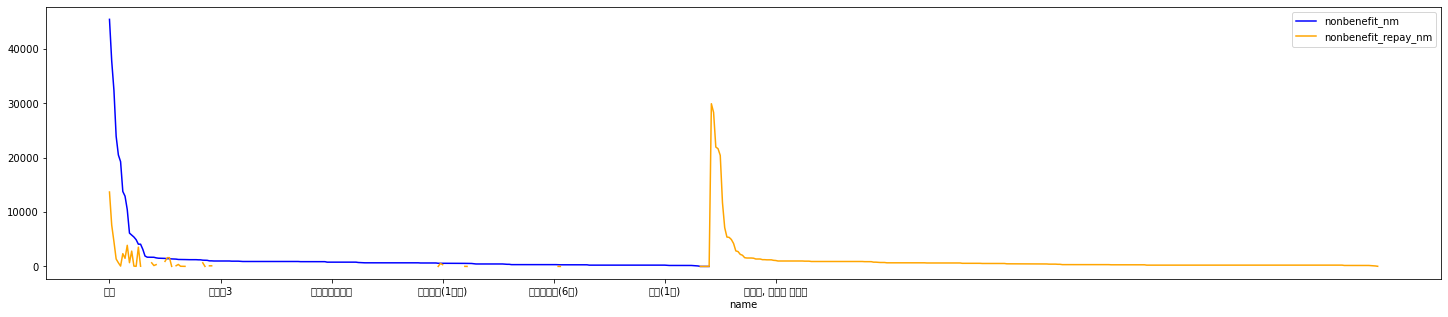

명칭비교 : 매핑결과


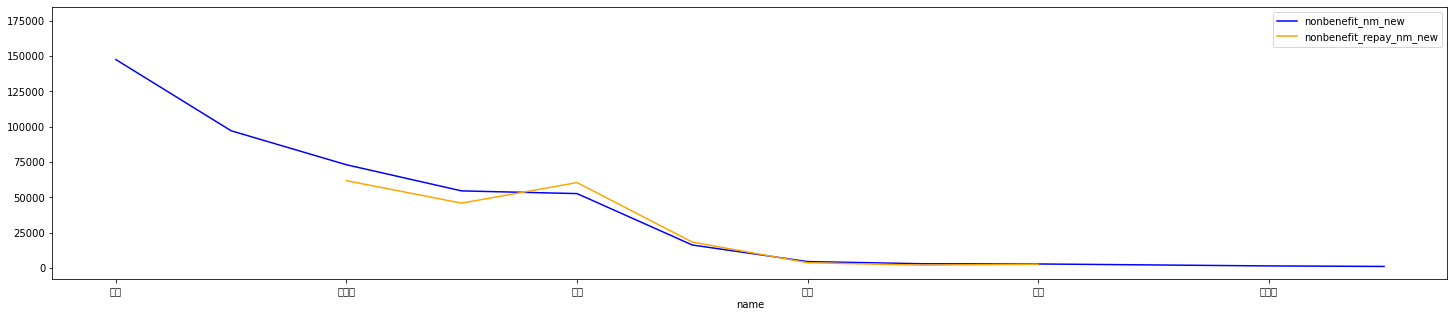

In [13]:
# 명칭비교 [:50]
tmp1 = daily_nonbenefit.nonbenefit_nm.value_counts().reset_index().rename(columns={'index':'name'})
tmp2 = daily_nonbenefit_repay.nonbenefit_repay_nm.value_counts().reset_index().rename(columns={'index':'name'})

tmp = tmp1.merge(tmp2, how='outer', left_on='name', right_on='name')

print('명칭비교 : 결제')
ax = tmp.plot(kind='line', x='name', y='nonbenefit_nm', color='blue', figsize=(25, 5))
tmp.plot(kind='line', x='name', y='nonbenefit_repay_nm', ax=ax, color='orange')
plt.show()

daily_nonbenefit = apply_treatment_dict(daily_nonbenefit, nm_col='nonbenefit_nm', no_col='nonbenefit_no')
daily_nonbenefit_repay = apply_treatment_dict(daily_nonbenefit_repay, nm_col='nonbenefit_repay_nm', no_col='nonbenefit_repay_no')

tmp1 = daily_nonbenefit.nonbenefit_nm_new.value_counts().reset_index().rename(columns={'index':'name'})
tmp2 = daily_nonbenefit_repay.nonbenefit_repay_nm_new.value_counts().reset_index().rename(columns={'index':'name'})

tmp = tmp1.merge(tmp2, how='outer', left_on='name', right_on='name')

print('명칭비교 : 매핑결과')
ax = tmp.plot(kind='line', x='name', y='nonbenefit_nm_new', color='blue', figsize=(25, 5))
tmp.plot(kind='line', x='name', y='nonbenefit_repay_nm_new', ax=ax, color='orange')
plt.show()

명칭비교 : 상담


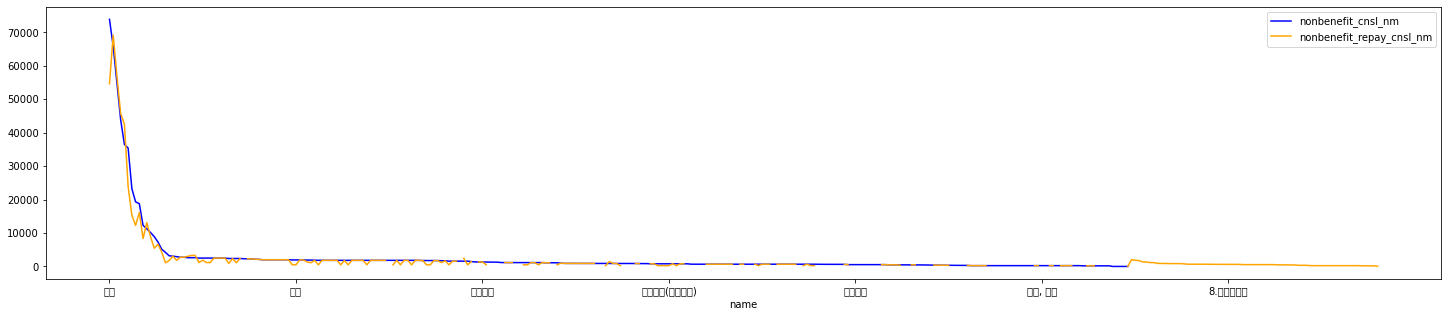

명칭비교 : 매핑결과


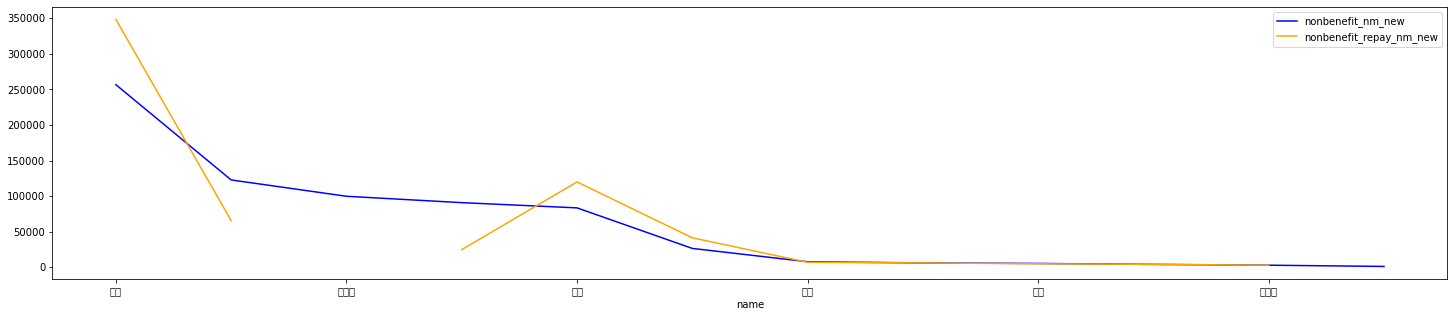

In [14]:
# 명칭비교 [:50]
tmp1 = daily_nonbenefit_detail_cnsl.nonbenefit_cnsl_nm.value_counts().reset_index().rename(columns={'index':'name'})
tmp2 = daily_nonbenefit_repay_detail_cnsl.nonbenefit_repay_cnsl_nm.value_counts().reset_index().rename(columns={'index':'name'})

tmp = tmp1.merge(tmp2, how='outer', left_on='name', right_on='name')

print('명칭비교 : 상담')
ax = tmp.plot(kind='line', x='name', y='nonbenefit_cnsl_nm', color='blue', figsize=(25, 5))
tmp.plot(kind='line', x='name', y='nonbenefit_repay_cnsl_nm', ax=ax, color='orange')
plt.show()

daily_nonbenefit_detail_cnsl = apply_treatment_dict(daily_nonbenefit_detail_cnsl, nm_col='nonbenefit_cnsl_nm', no_col='nonbenefit_cnsl_no')
daily_nonbenefit_repay_detail_cnsl = apply_treatment_dict(daily_nonbenefit_repay_detail_cnsl, nm_col='nonbenefit_repay_cnsl_nm', no_col='nonbenefit_repay_cnsl_no')

tmp1 = daily_nonbenefit_detail_cnsl.nonbenefit_nm_new.value_counts().reset_index().rename(columns={'index':'name'})
tmp2 = daily_nonbenefit_repay_detail_cnsl.nonbenefit_repay_nm_new.value_counts().reset_index().rename(columns={'index':'name'})

tmp = tmp1.merge(tmp2, how='outer', left_on='name', right_on='name')

print('명칭비교 : 매핑결과')
ax = tmp.plot(kind='line', x='name', y='nonbenefit_nm_new', color='blue', figsize=(25, 5))
tmp.plot(kind='line', x='name', y='nonbenefit_repay_nm_new', ax=ax, color='orange')
plt.show()

# 진료 로직체크

[daily_nonbenefit] 쉬는 날에 진료기록:
전체 데이터의 16.6%, 75,908건
해당 데이터를 이슈 파일로 저장합니다.
---------------------------------------------------

[daily_nonbenefit] 쉬는 날에 매출기록:
전체 데이터의 0.0%, 225건


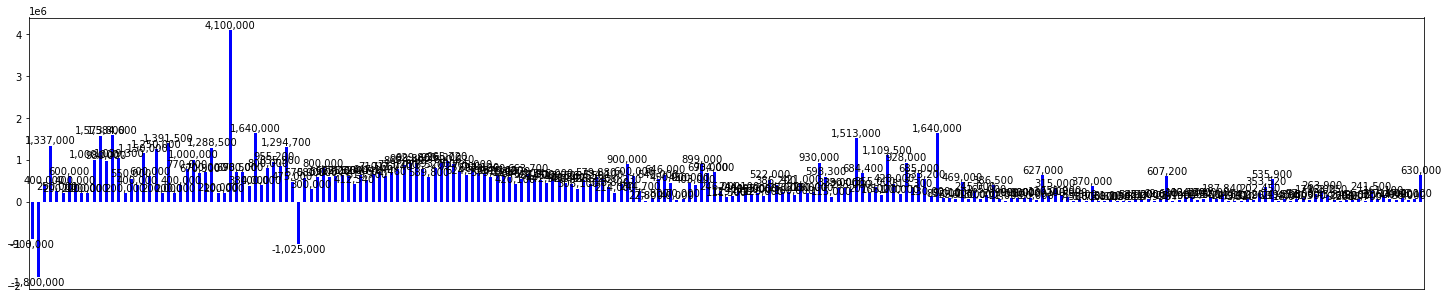

해당 데이터를 이슈 파일로 저장합니다.
---------------------------------------------------

[daily_nonbenefit_detail_cnsl] 쉬는 날에 진료기록:
전체 데이터의 17.0%, 120,427건
해당 데이터를 이슈 파일로 저장합니다.
---------------------------------------------------

[daily_nonbenefit_repay] 쉬는 날에 진료기록:
전체 데이터의 16.9%, 62,860건
해당 데이터를 이슈 파일로 저장합니다.
---------------------------------------------------

[daily_nonbenefit_repay] 쉬는 날에 매출기록:
전체 데이터의 0.0%, 22건


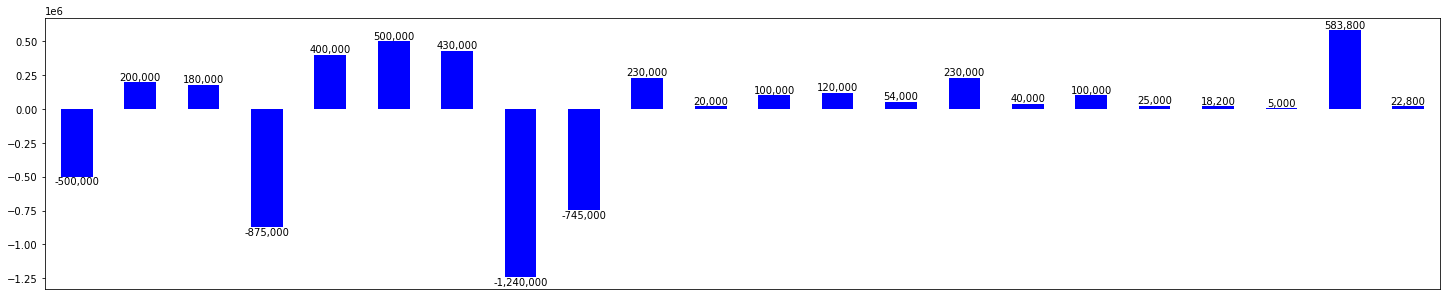

해당 데이터를 이슈 파일로 저장합니다.
---------------------------------------------------

[daily_nonbenefit_repay_detail_cnsl] 쉬는 날에 진료기록:
전체 데이터의 17.6%, 110,122건
해당 데이터를 이슈 파일로 저장합니다.
---------------------------------------------------



In [15]:
# 성과없는 진료기록
for df_name in df_list:
    
    if df_name == 'daily_nonbenefit' or \
        df_name == 'daily_nonbenefit_detail_cnsl':
        nm_col = 'nonbenefit_nm_new'
        pay_col = 'nonbenefit_pay'
        treatment_outlier_print(globals()[df_name], nm_col, pay_col)
        
    elif df_name == 'daily_nonbenefit_repay' or \
        df_name == 'daily_nonbenefit_repay_detail_cnsl':
        df = globals()[df_name].copy()
        nm_col = 'nonbenefit_repay_nm_new'
        pay_col = 'nonbenefit_repay'
        treatment_outlier_print(globals()[df_name], nm_col, pay_col)

# 영업일수 규칙 불합치

In [16]:
for df_name in df_list:
    df = globals()[df_name]
    if 'monthly' in df_name:
        # 월, ≠ null, > 31
        if len(df) > 0 and len(df[df.biz_cnt.notnull()]) > 0:
            outlier = df[df.biz_cnt.notnull()]
            print(Colors.YELLOW + f'[{df_name}] Biz_cnt 월 입력규칙 불합치:' + Colors.END)
            # print(Colors.YELLOW + f'[월 Biz_cnt]에 널이 아닌 기록:' + Colors.END)
            print(f'전체의 {len(outlier)/len(df)*100:.1f}%, {len(outlier)}건\n')
            print('---------------------------------------------------\n')

        if len(df) > 0 and len(df[df.biz_cnt > 31]) > 0:
            outlier = df[df.biz_cnt > 31]
            print(Colors.YELLOW + f'[{df_name}] Biz_cnt 31일 초과:' + Colors.END)
            # print(Colors.YELLOW + f'[월 Biz_cnt]에 31일 초과 기록:' + Colors.END)
            print(f'전체의 {len(outlier)/len(df)*100:.1f}%, {len(outlier)}건\n')
            print('---------------------------------------------------\n')

    else:
        # 일, ≠ 1 or 0, = null
        if len(df) > 0 and df.biz_cnt.isna().mean() > 0:
            outlier = df[df.biz_cnt.isna()]
            print(Colors.YELLOW + f'[{df_name}] Biz_cnt 일 입력규칙 불합치:' + Colors.END)
            # print(Colors.YELLOW + f'[일 Biz_cnt]에 결측치:' + Colors.END)
            print(f'전체의 {len(outlier)/len(df)*100:.1f}%, {len(outlier)}건\n')
            print('---------------------------------------------------\n')
            
        if len(df) > 0 and len(df[df.biz_cnt > 1]) > 0:
            outlier = df[df.biz_cnt > 1]
            print(Colors.YELLOW + f'[{df_name}] Biz_cnt 1 초과:' + Colors.END)
            # print(Colors.YELLOW + f'[일 Biz_cnt]에 1일 초과 기록:' + Colors.END)
            print(f'전체의 {len(outlier)/len(df)*100:.1f}%, {len(outlier)}건')
            print('---------------------------------------------------\n')

[monthly_appointment] Biz_cnt 월 입력규칙 불합치:
전체의 24.2%, 673건

---------------------------------------------------

[monthly_appointment] Biz_cnt 31일 초과:
전체의 10.2%, 284건

---------------------------------------------------

[monthly_nonbenefit_repay_cnsl] Biz_cnt 월 입력규칙 불합치:
전체의 78.3%, 7616건

---------------------------------------------------

[monthly_nonbenefit_repay_cnsl] Biz_cnt 31일 초과:
전체의 0.5%, 53건

---------------------------------------------------

[monthly_nonbenefit_cnsl] Biz_cnt 월 입력규칙 불합치:
전체의 13.8%, 338건

---------------------------------------------------

[monthly_nonbenefit_cnsl] Biz_cnt 31일 초과:
전체의 2.2%, 53건

---------------------------------------------------

[monthly_revenue] Biz_cnt 월 입력규칙 불합치:
전체의 17.6%, 466건

---------------------------------------------------

[monthly_revenue] Biz_cnt 31일 초과:
전체의 7.9%, 210건

---------------------------------------------------

[monthly_patients] Biz_cnt 월 입력규칙 불합치:
전체의 23.5%, 667건

------------------------------------------------

# 건수 규칙 불합치

monthly_appointment에 건수 불일치 기록:
예약 ≠ 진료 + 취소 + 노쇼
8.42%, 234건


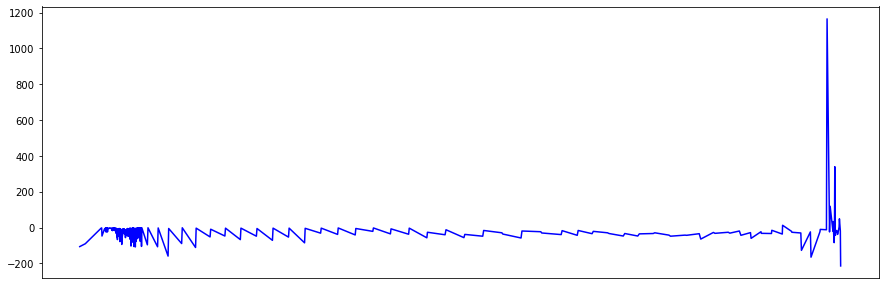

해당 데이터를 이슈 파일로 저장합니다.
---------------------------------------------------

monthly_nonbenefit_repay_cnsl에 건수 불일치 기록:
상담 ≠ 성공 + 실패
0.35%, 34건


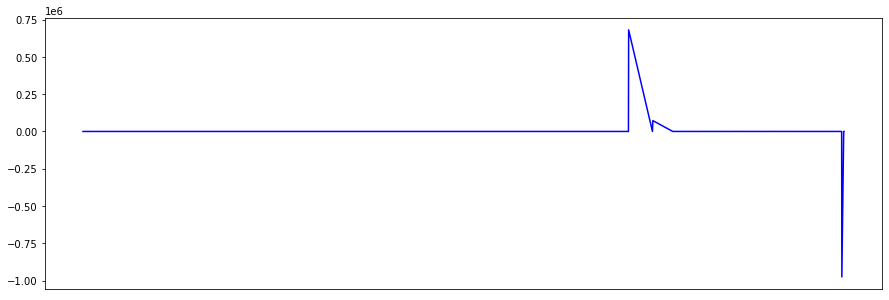

해당 데이터를 이슈 파일로 저장합니다.
---------------------------------------------------

monthly_nonbenefit_cnsl에 건수 불일치 기록:
상담 ≠ 성공 + 실패
1.72%, 42건


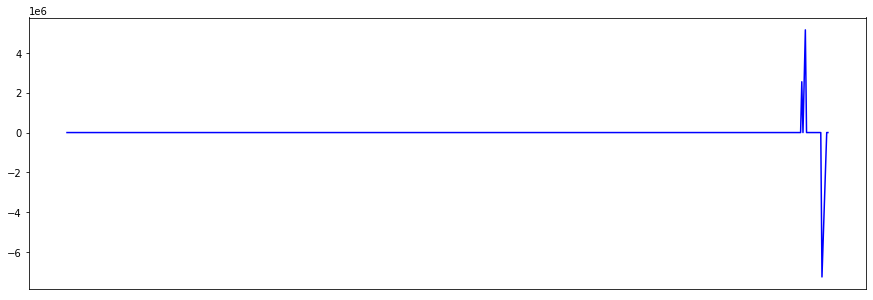

해당 데이터를 이슈 파일로 저장합니다.
---------------------------------------------------

daily_patients에 건수 불일치 기록:
내원 ≠ 초진 + 재진
22.21%, 35,909건


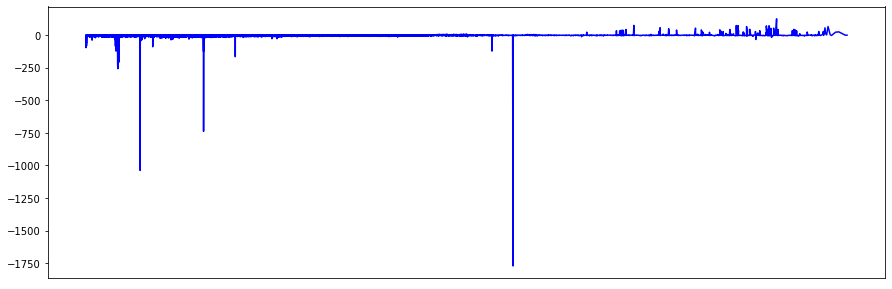

해당 데이터를 이슈 파일로 저장합니다.
---------------------------------------------------

daily_nonbenefit_detail_cnsl에 건수 불일치 기록:
상담 < 성공
0.16%, 1,124건


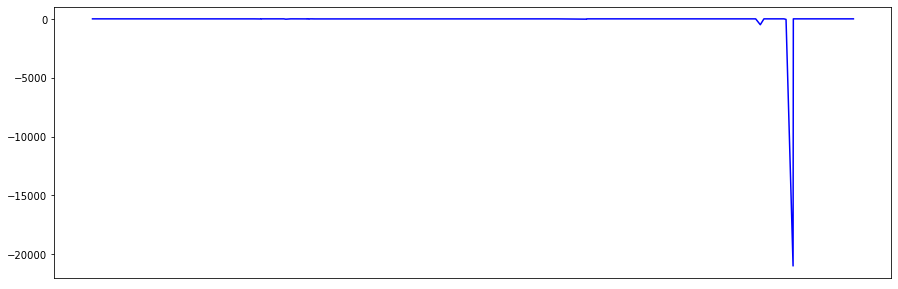

해당 데이터를 이슈 파일로 저장합니다.
---------------------------------------------------

monthly_patients에 건수 불일치 기록:
내원 ≠ 초진 + 재진
39.22%, 1,115건


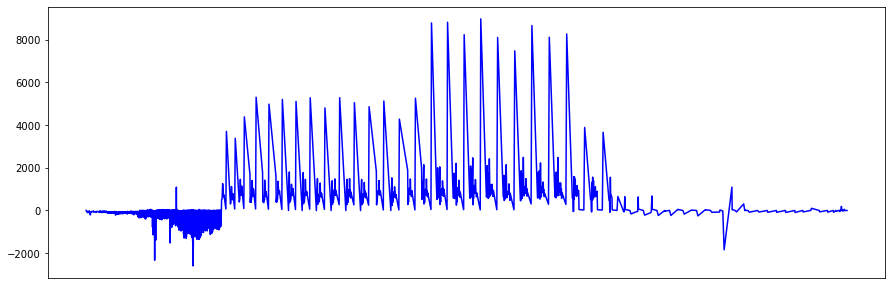

해당 데이터를 이슈 파일로 저장합니다.
---------------------------------------------------

daily_appointment에 건수 불일치 기록:
예약 ≠ 진료 + 취소 + 노쇼
2.07%, 3,497건


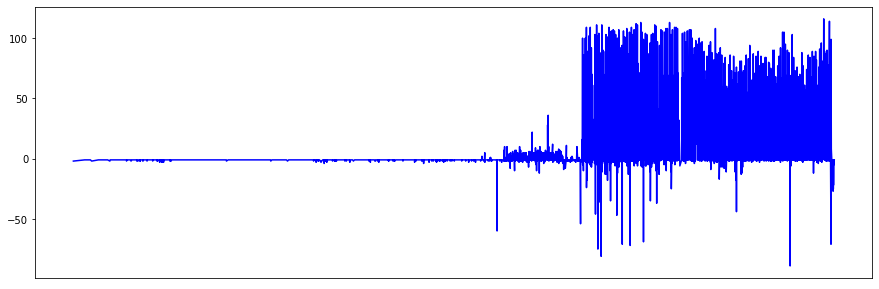

해당 데이터를 이슈 파일로 저장합니다.
---------------------------------------------------

daily_nonbenefit_repay_cnsl에 건수 불일치 기록:
상담 ≠ 성공 + 실패
1.04%, 874건


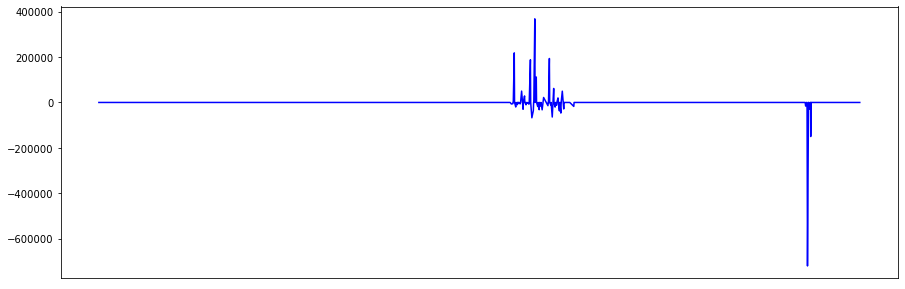

해당 데이터를 이슈 파일로 저장합니다.
---------------------------------------------------

daily_nonbenefit_repay_detail_cnsl에 건수 불일치 기록:
상담 < 성공
0.09%, 570건


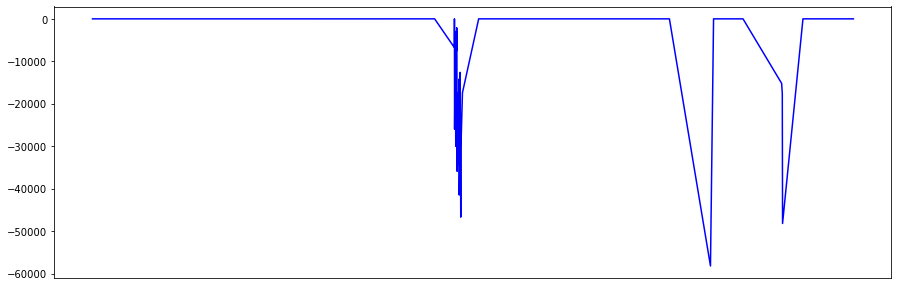

해당 데이터를 이슈 파일로 저장합니다.
---------------------------------------------------

daily_nonbenefit_cnsl에 건수 불일치 기록:
상담 ≠ 성공 + 실패
2.02%, 1,793건


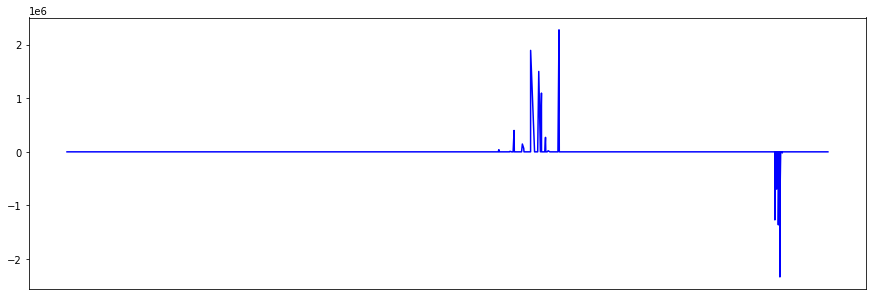

해당 데이터를 이슈 파일로 저장합니다.
---------------------------------------------------



In [17]:
# total counts ≠ part counts
for df_name in df_list:
 
    df = globals()[df_name].copy()
 
    # cnsl ≠ succ + fail
    if 'nonbenefit_repay_cnsl' in df_name:
        outlier = df.fillna(0).query(
            'nonbenefit_repay_cnsl_cnt \
            - (nonbenefit_repay_cnsl_succ_cnt + nonbenefit_repay_cnsl_fail_cnt) != 0'
        )
        if len(outlier) > 0:
            outlier['gap'] = outlier.nonbenefit_repay_cnsl_cnt - \
                (outlier.nonbenefit_repay_cnsl_succ_cnt + outlier.nonbenefit_repay_cnsl_fail_cnt)
            issue_msg = '상담 ≠ 성공 + 실패'
            print_count_mismatch(outlier, df_name, len(df), issue_msg)
            print('---------------------------------------------------\n')

    elif 'nonbenefit_cnsl' in df_name:
        outlier = df.fillna(0).query(
            'nonbenefit_cnsl_cnt \
            - (nonbenefit_cnsl_succ_cnt + nonbenefit_cnsl_fail_cnt) != 0'
        )
        if len(outlier) > 0:
            outlier['gap'] = outlier.nonbenefit_cnsl_cnt - \
                (outlier.nonbenefit_cnsl_succ_cnt + outlier.nonbenefit_cnsl_fail_cnt)
            issue_msg = '상담 ≠ 성공 + 실패'
            print_count_mismatch(outlier, df_name, len(df), issue_msg)
            print('---------------------------------------------------\n')

    # cnsl < succ
    elif 'nonbenefit_detail_cnsl' in df_name:
        df = df.fillna(0)
        outlier = df[df['nonbenefit_cnsl_cnt'] < df['nonbenefit_cnsl_succ_cnt']]
        
        # outlier = df.fillna(0).query(
        #     'nonbenefit_cnsl_cnt - nonbenefit_cnsl_succ_cnt < 0'
        # )
        if len(outlier) > 0:
            outlier['gap'] = outlier.nonbenefit_cnsl_cnt - outlier.nonbenefit_cnsl_succ_cnt
            issue_msg = '상담 < 성공'
            print_count_mismatch(outlier, df_name, len(df), issue_msg)
            print('---------------------------------------------------\n')
            
    elif 'nonbenefit_repay_detail_cnsl' in df_name:
        df = df.fillna(0)
        outlier = df[df['nonbenefit_repay_cnsl_cnt'] < df['nonbenefit_repay_cnsl_succ_cnt']]

        # outlier = df.fillna(0).query(
        #     'nonbenefit_repay_cnsl_cnt - nonbenefit_repay_cnsl_succ_cnt < 0'
        # )
        if len(outlier) > 0:
            outlier['gap'] = outlier.nonbenefit_repay_cnsl_cnt - outlier.nonbenefit_repay_cnsl_succ_cnt
            issue_msg = '상담 < 성공'
            print_count_mismatch(outlier, df_name, len(df), issue_msg)
            print('---------------------------------------------------\n')

    # visit ≠ first + revisit
    elif 'patients' in df_name:
        outlier = df.fillna(0).query(
            'visit_cnt - (fstvisit_cnt + revisit_cnt) != 0'
        )
        if len(outlier) > 0:
            outlier['gap'] = outlier.visit_cnt - \
                (outlier.fstvisit_cnt + outlier.revisit_cnt)
            issue_msg = '내원 ≠ 초진 + 재진'
            print_count_mismatch(outlier, df_name, len(df), issue_msg)
            print('---------------------------------------------------\n')

    # appointment ≠ fulfill + cancel + noshow
    elif 'appointment' in df_name:
        outlier = df.fillna(0).query(
            'appointment_cnt - (fulfillment_cnt + cancel_cnt + noshow_cnt) != 0'
        )
        if len(outlier) > 0:
            outlier['gap'] = outlier.appointment_cnt - \
                (outlier.fulfillment_cnt + outlier.cancel_cnt + outlier.noshow_cnt)
            issue_msg = '예약 ≠ 진료 + 취소 + 노쇼'
            print_count_mismatch(outlier, df_name, len(df), issue_msg)
            print('---------------------------------------------------\n')

# 날짜 결측치

monthly_appointment에 biz_dt 결측치:
전체의 0.14%, 4건


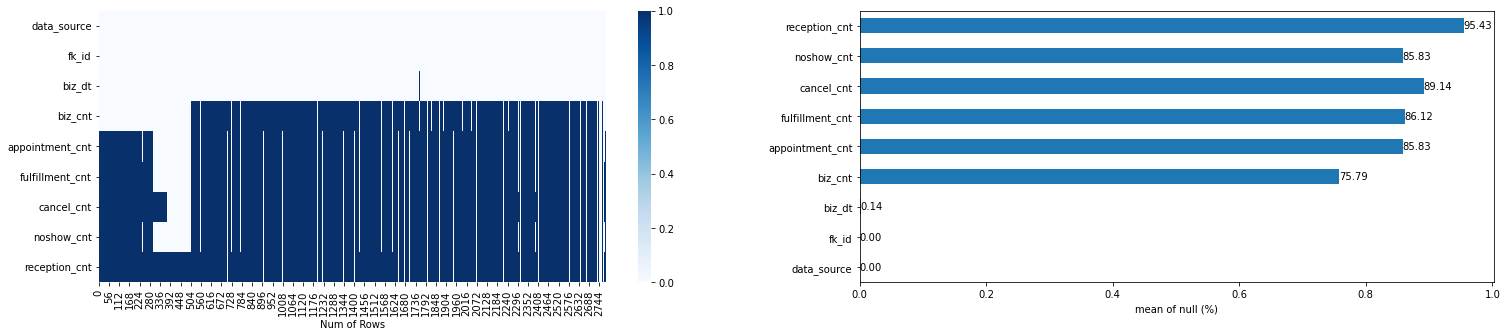

해당 결측치를 제거했습니다.

결측치 제거 확인:


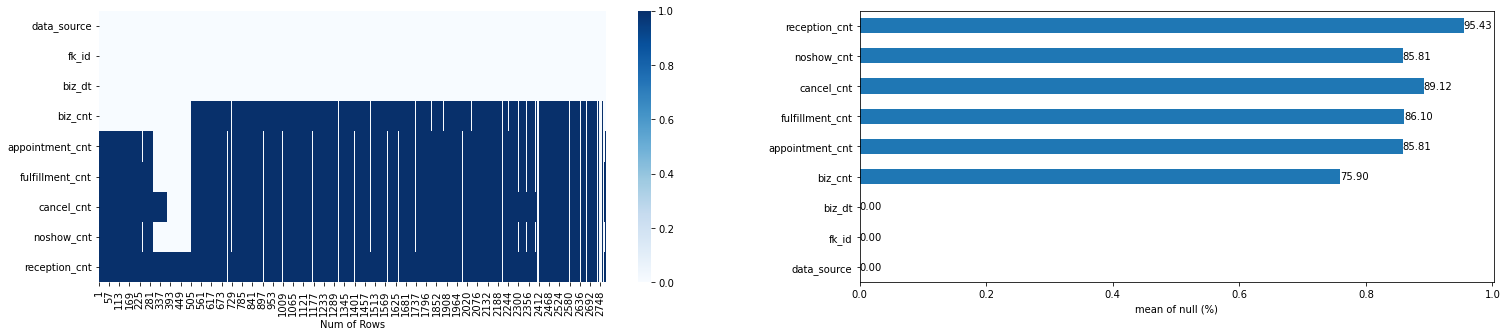

---------------------------------------------------

monthly_nonbenefit_repay_cnsl에 biz_dt 결측치:
전체의 0.01%, 1건


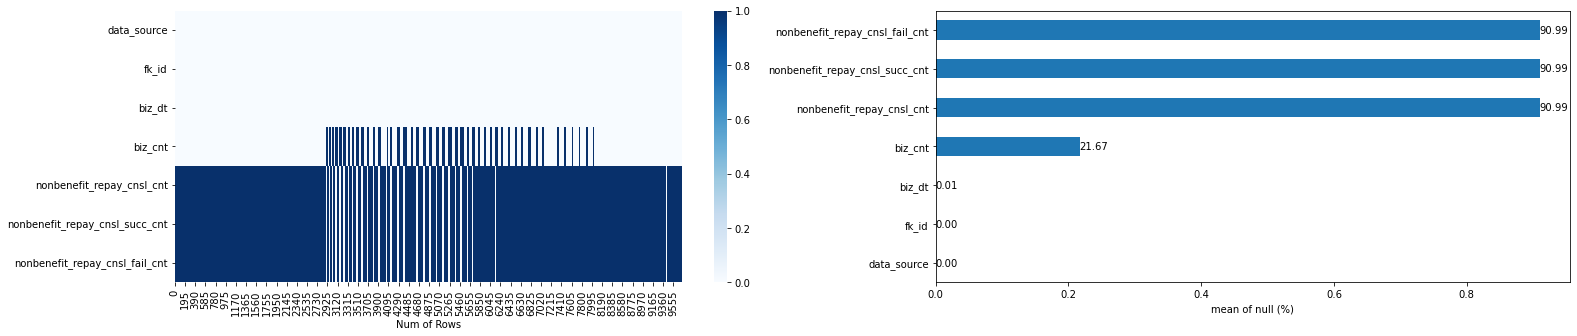

해당 결측치를 제거했습니다.

결측치 제거 확인:


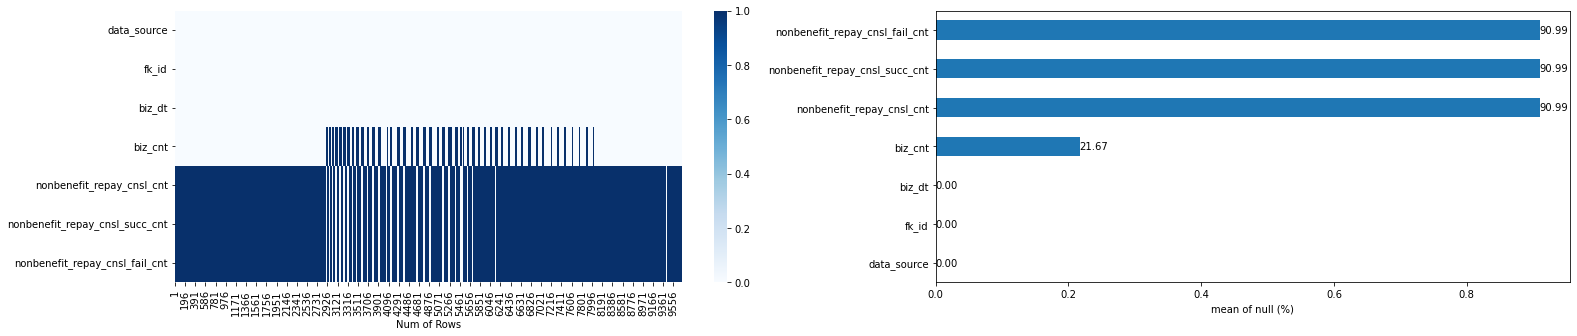

---------------------------------------------------

monthly_nonbenefit_cnsl에 biz_dt 결측치:
전체의 0.04%, 1건


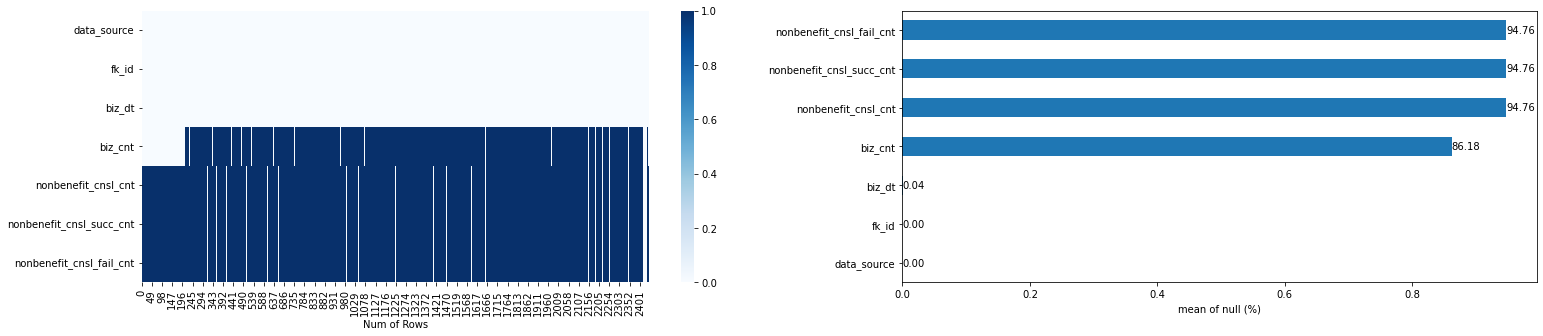

해당 결측치를 제거했습니다.

결측치 제거 확인:


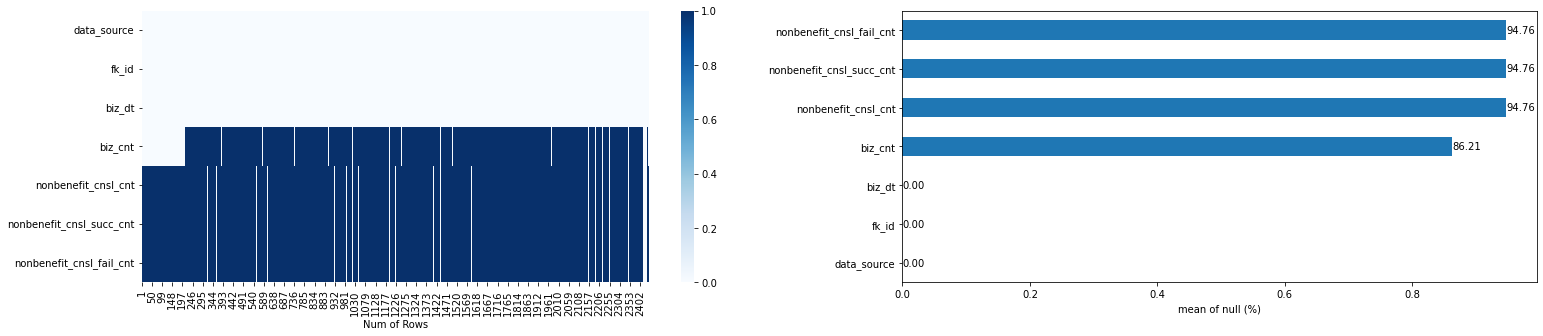

---------------------------------------------------

monthly_revenue에 biz_dt 결측치:
전체의 0.08%, 2건


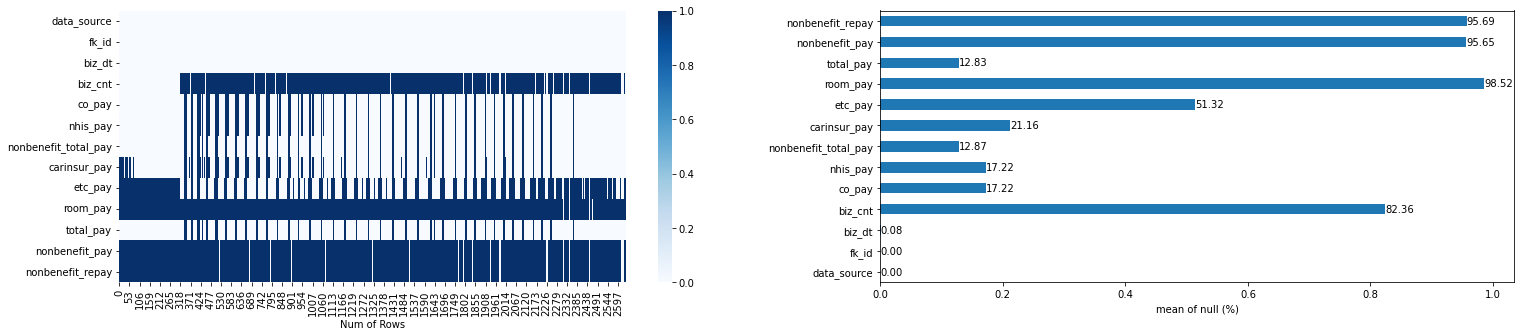

해당 결측치를 제거했습니다.

결측치 제거 확인:


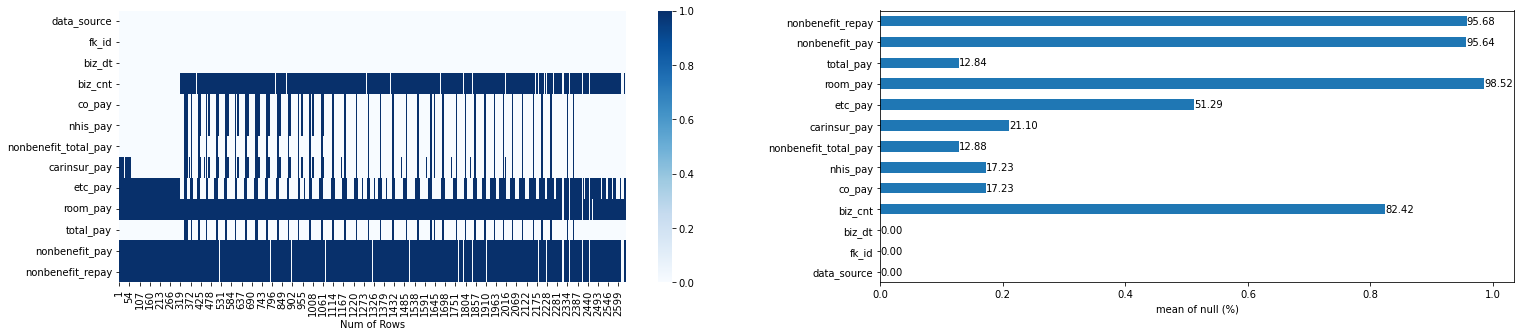

---------------------------------------------------

monthly_patients에 biz_dt 결측치:
전체의 0.14%, 4건


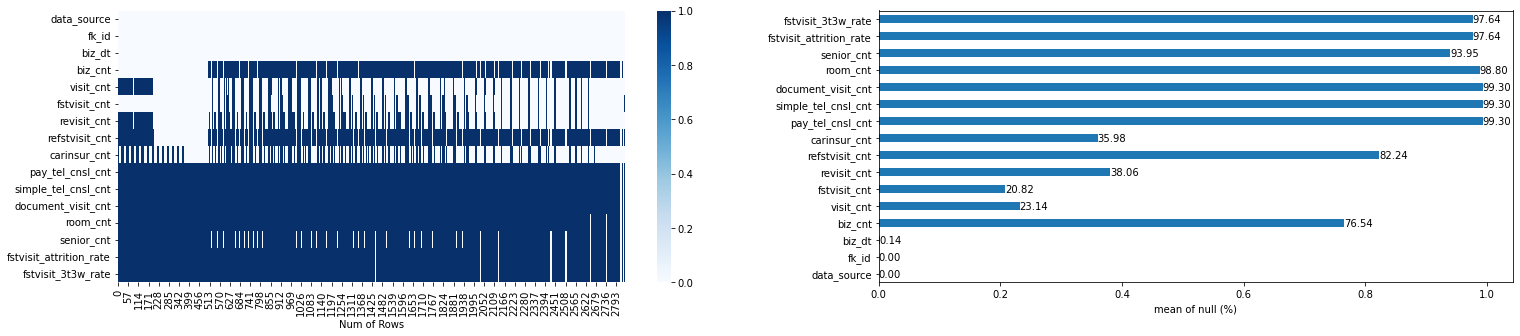

해당 결측치를 제거했습니다.

결측치 제거 확인:


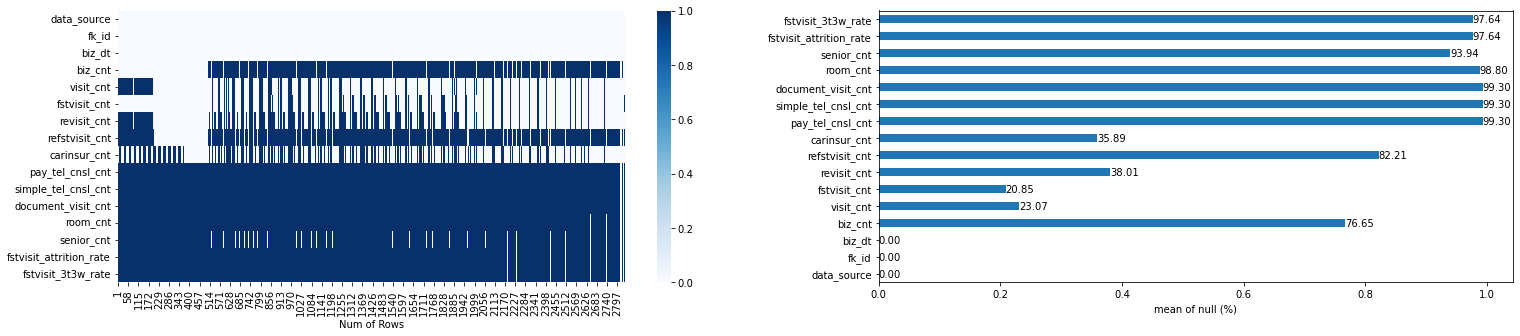

---------------------------------------------------



In [18]:
# NaT 탐색, 제거
for df_name in df_list:
    df = globals()[df_name].copy()
    biz_dt_nan = df.biz_dt.isna().sum()
    if biz_dt_nan > 0:
        print(Colors.YELLOW + f'{df_name}에 biz_dt 결측치:' + Colors.END)
        print(f'전체의 {biz_dt_nan/df.shape[0]*100:.2f}%, {biz_dt_nan}건')
        missing_value_plot(df)
        
        df = df.dropna(subset=['biz_dt'], axis=0)
        print('해당 결측치를 제거했습니다.\n')
        
        print('결측치 제거 확인:')
        missing_value_plot(df)
        print('---------------------------------------------------\n')

# 수치형 데이터 이상치 탐색
Z-Score 메소드를 이용해서 수치형 데이터의 이상치를 탐색, 조치한다.

Z-Score = (관측치 - 평균) / 표준편차

daily_nonbenefit.nonbenefit_pay 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.15%, 682건


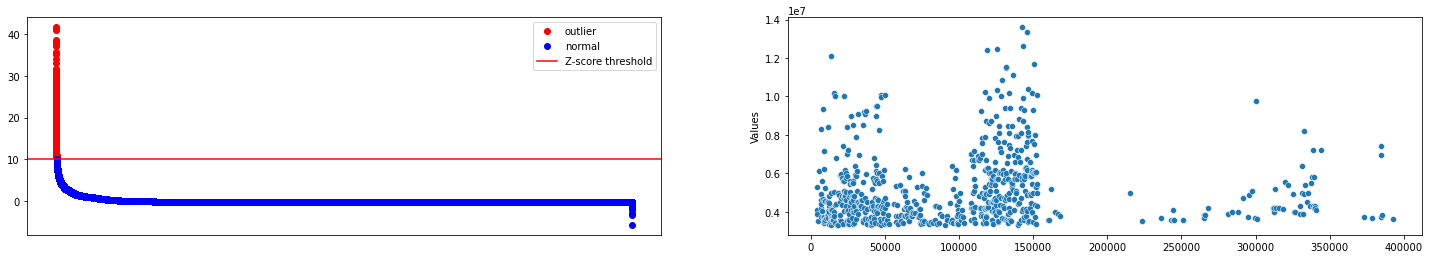

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_appointment.biz_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.18%, 5건


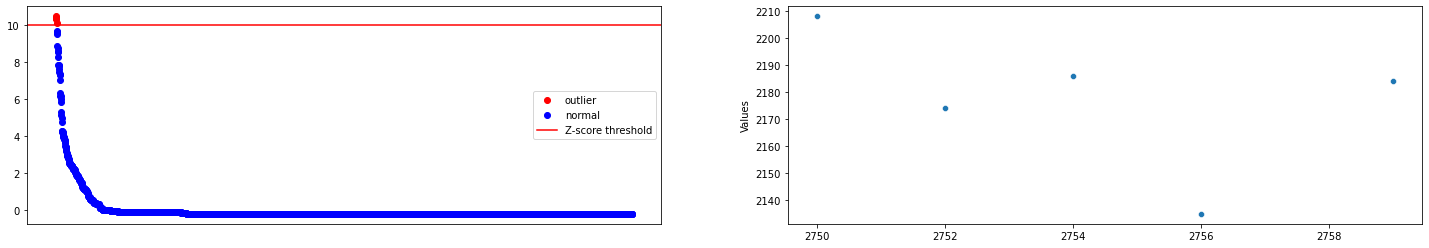

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_appointment.appointment_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.47%, 13건


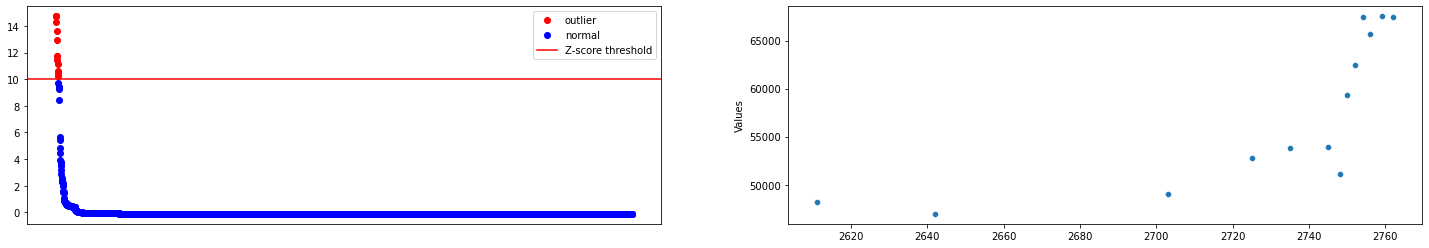

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_appointment.fulfillment_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.47%, 13건


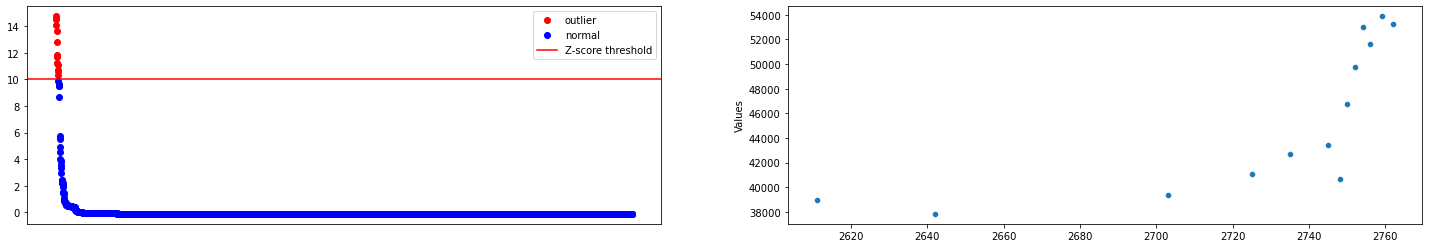

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_appointment.cancel_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.40%, 11건


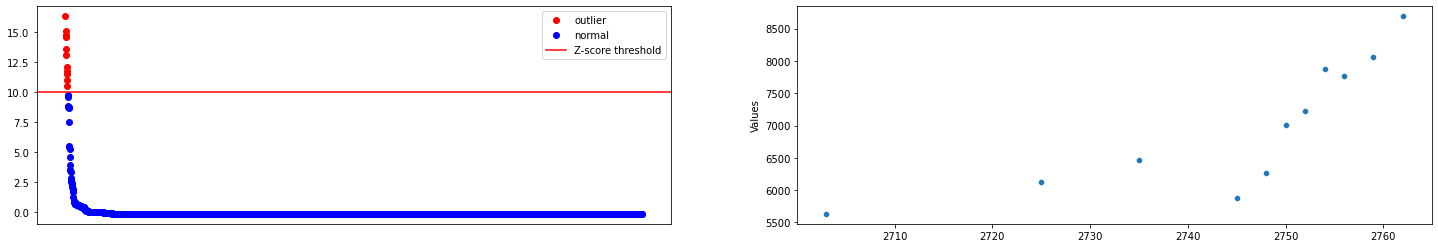

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_appointment.noshow_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.47%, 13건


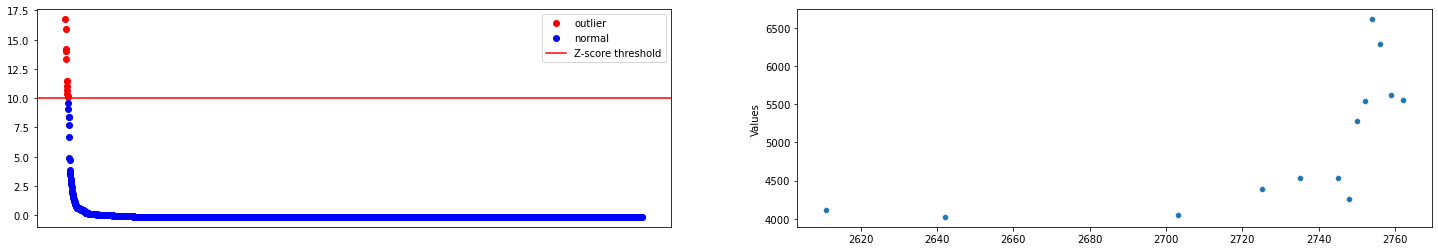

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_appointment.reception_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.36%, 10건


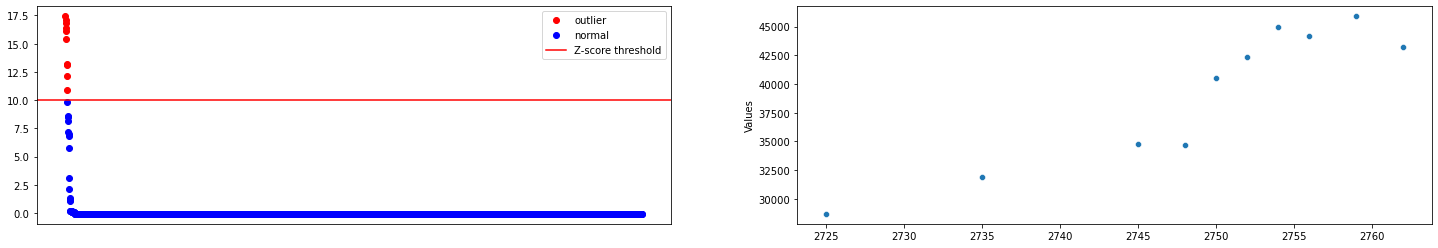

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_nonbenefit_repay_cnsl.biz_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.23%, 22건


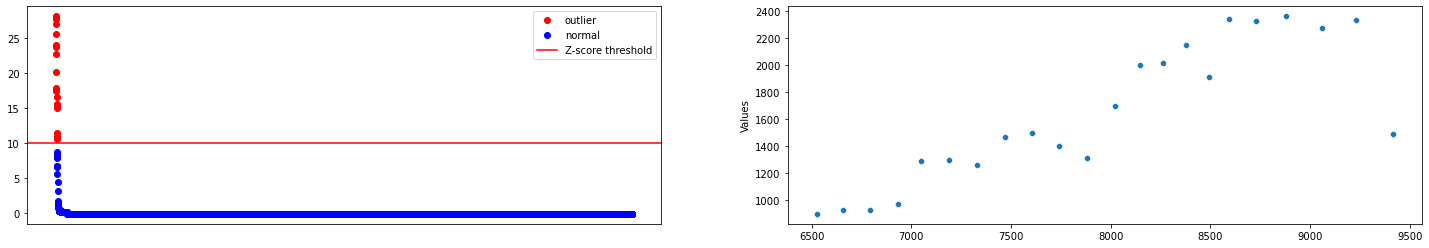

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_nonbenefit_repay_cnsl.nonbenefit_repay_cnsl_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.02%, 2건


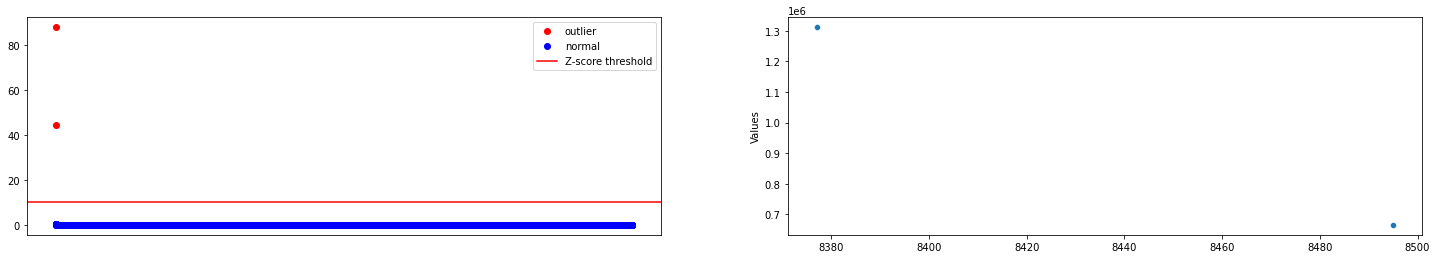

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_nonbenefit_repay_cnsl.nonbenefit_repay_cnsl_succ_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.02%, 2건


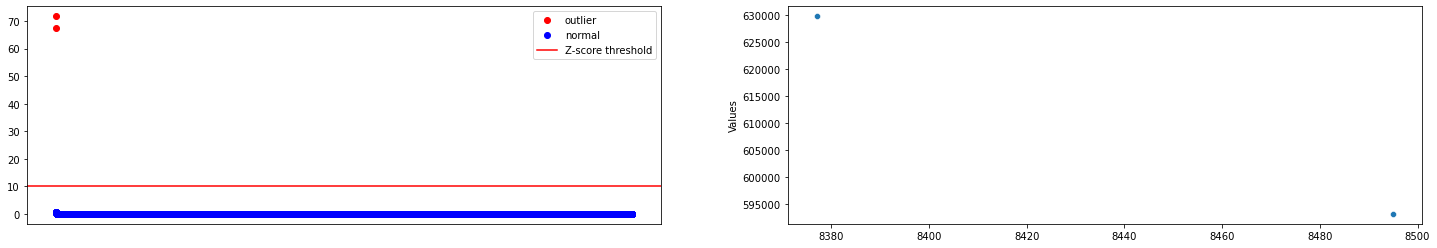

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_nonbenefit_repay_cnsl.nonbenefit_repay_cnsl_fail_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.01%, 1건


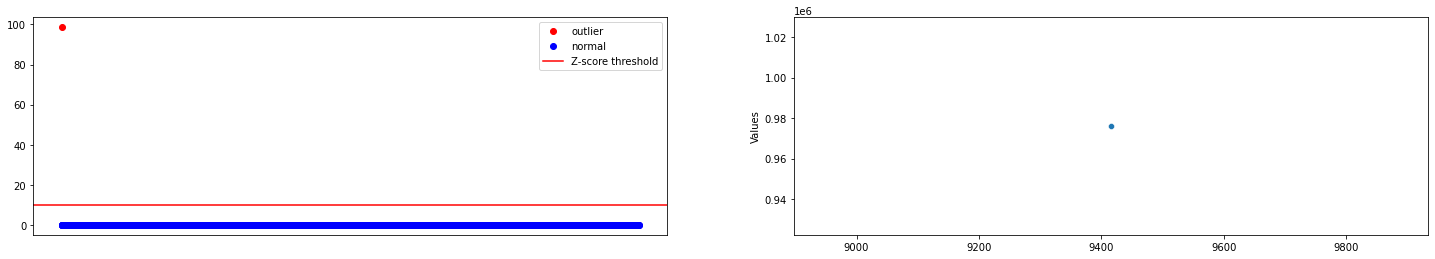

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_nonbenefit_cnsl.biz_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.41%, 10건


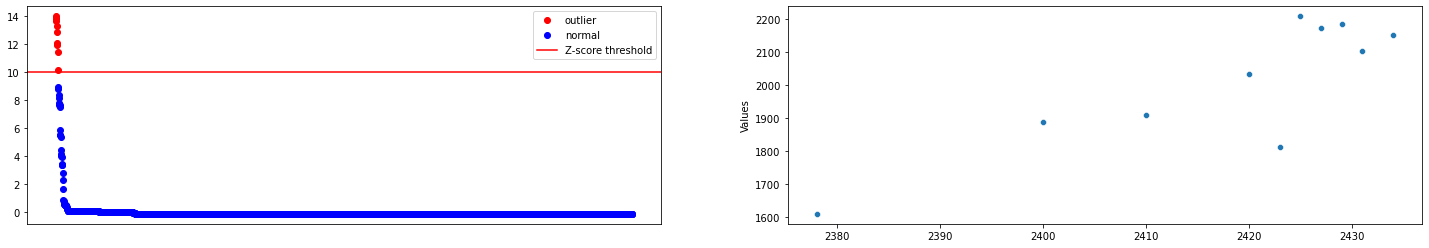

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_nonbenefit_cnsl.nonbenefit_cnsl_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.08%, 2건


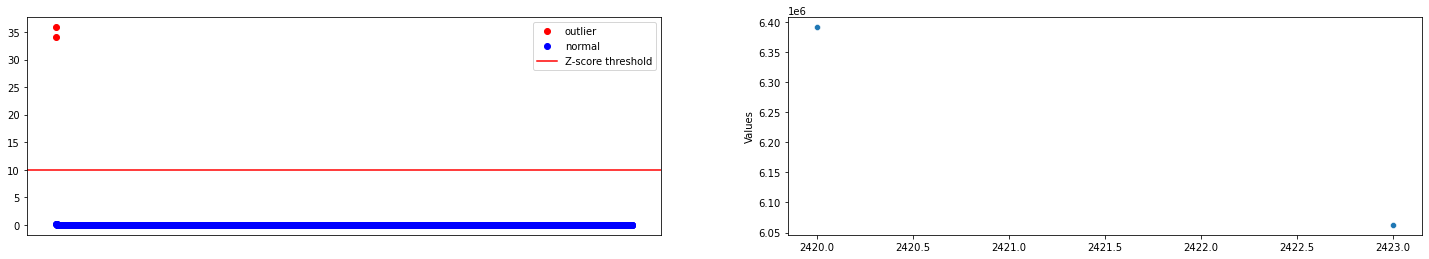

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_nonbenefit_cnsl.nonbenefit_cnsl_succ_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.08%, 2건


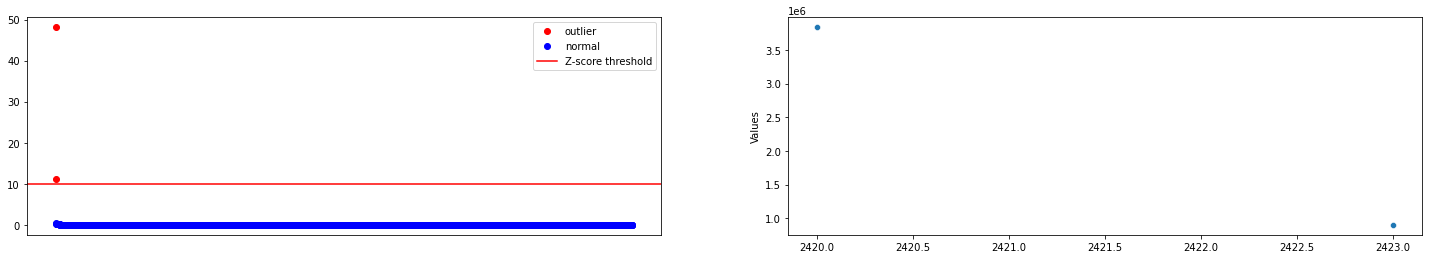

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_nonbenefit_cnsl.nonbenefit_cnsl_fail_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.04%, 1건


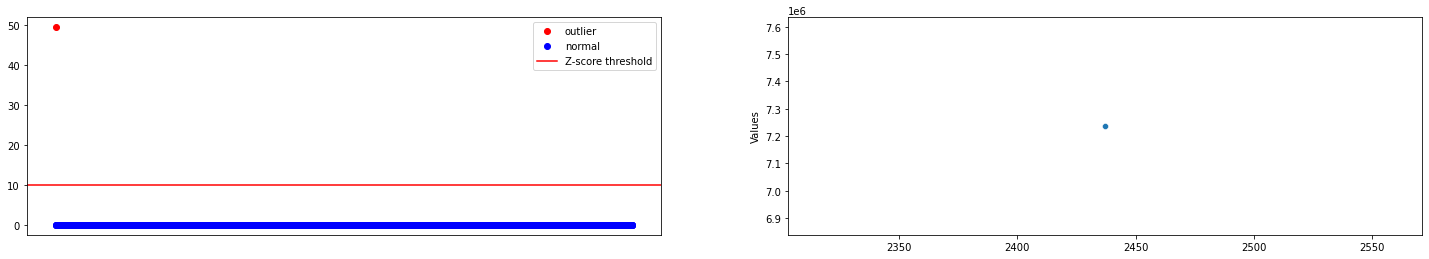

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_patients.fstvisit_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.00%, 8건


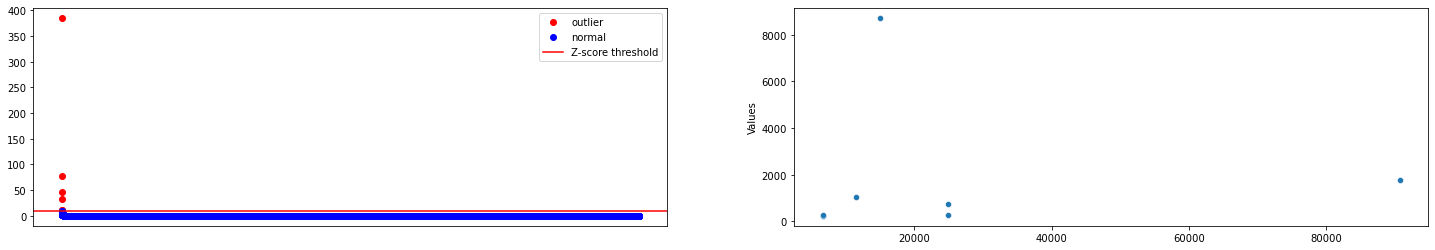

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_patients.revisit_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.00%, 1건


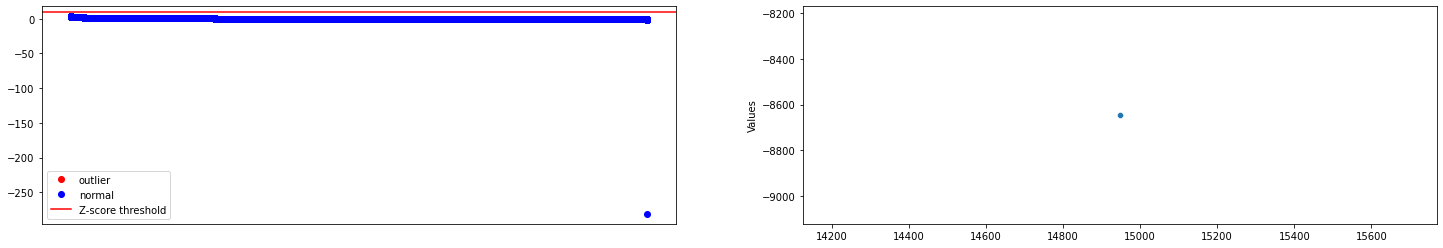

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_patients.refstvisit_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.01%, 19건


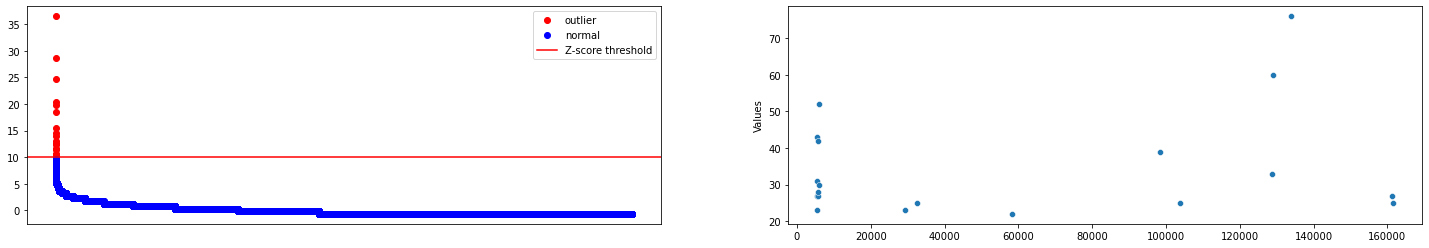

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_patients.carinsur_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.05%, 76건


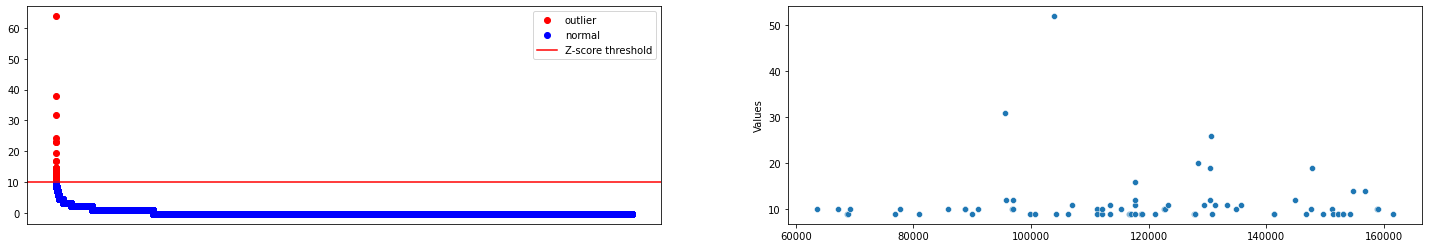

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_patients.pay_tel_cnsl_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.18%, 283건


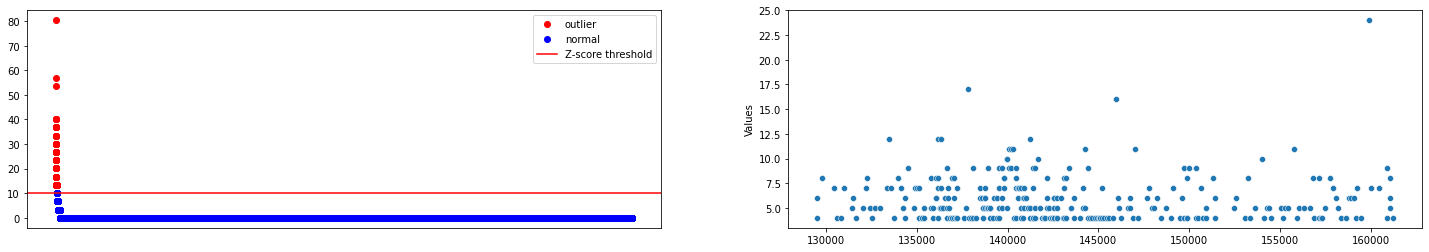

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_patients.simple_tel_cnsl_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.16%, 256건


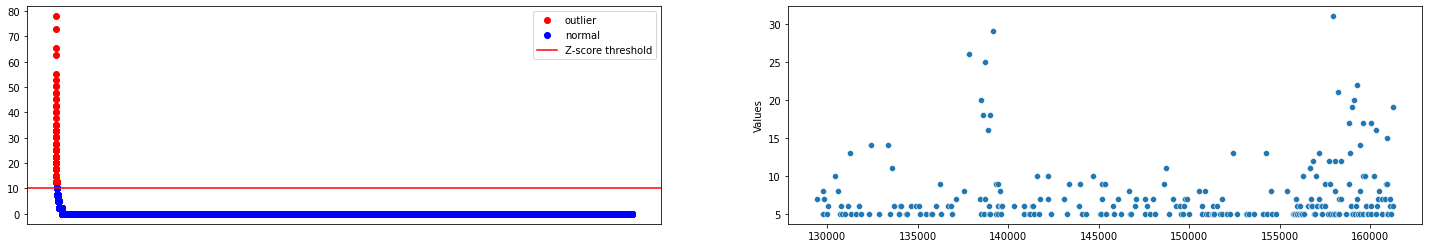

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_patients.document_visit_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.21%, 347건


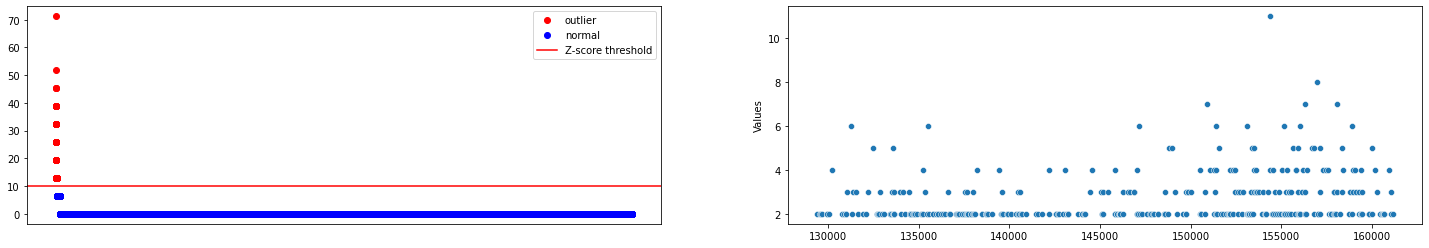

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_patients.room_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.45%, 727건


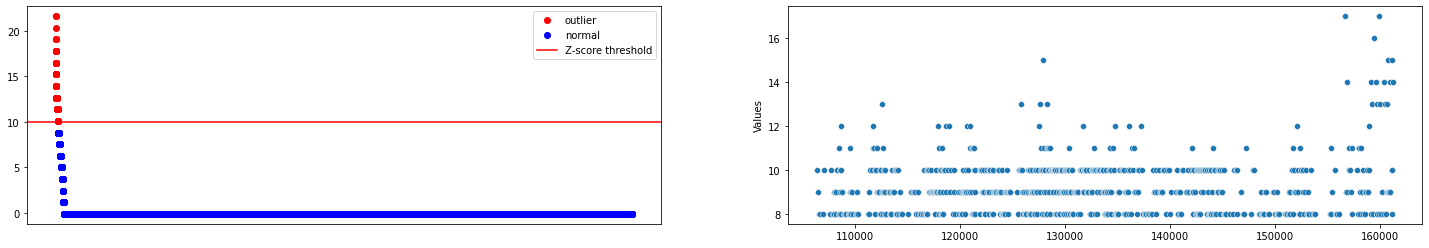

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_patients.senior_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.00%, 1건


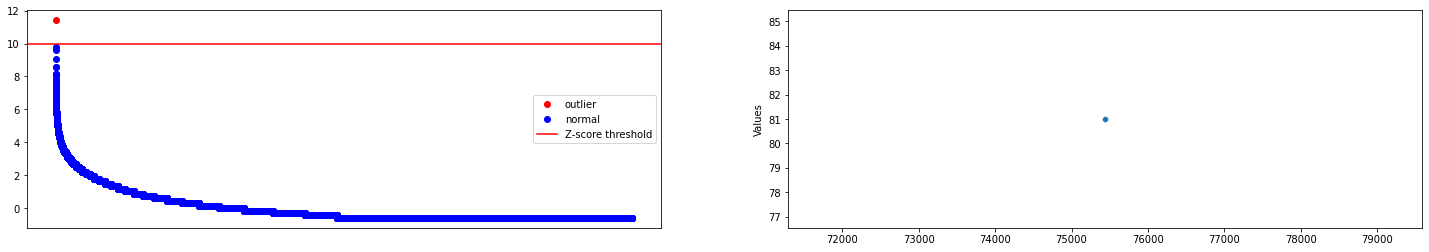

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_patients.fstvisit_attrition_rate 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.01%, 10건


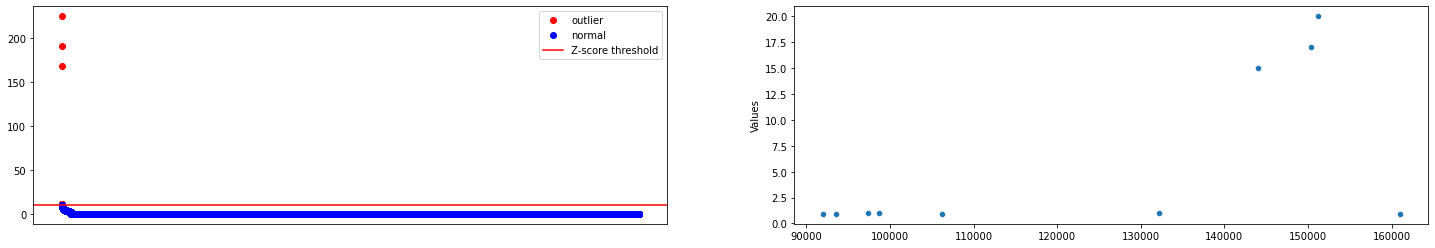

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_patients.fstvisit_3t3w_rate 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.00%, 3건


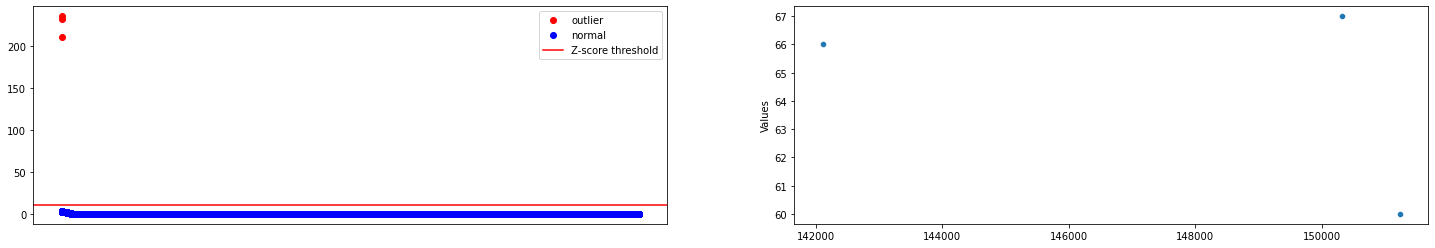

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_nonbenefit_detail_cnsl.nonbenefit_cnsl_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.01%, 44건


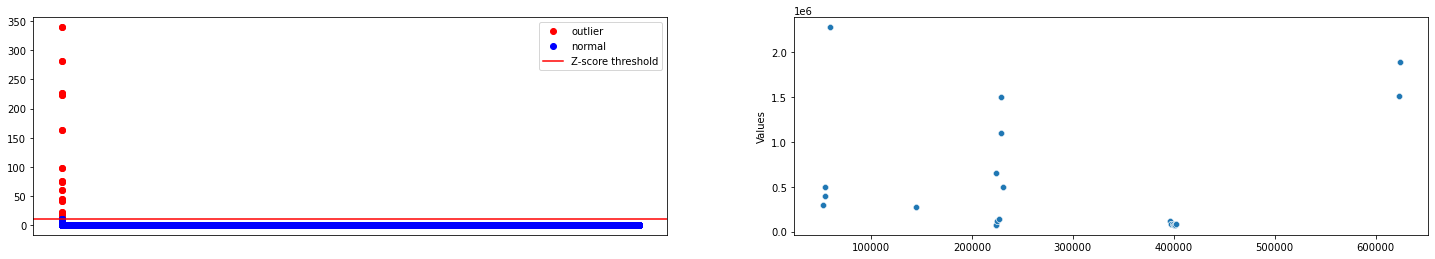

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_nonbenefit_detail_cnsl.nonbenefit_cnsl_succ_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.01%, 38건


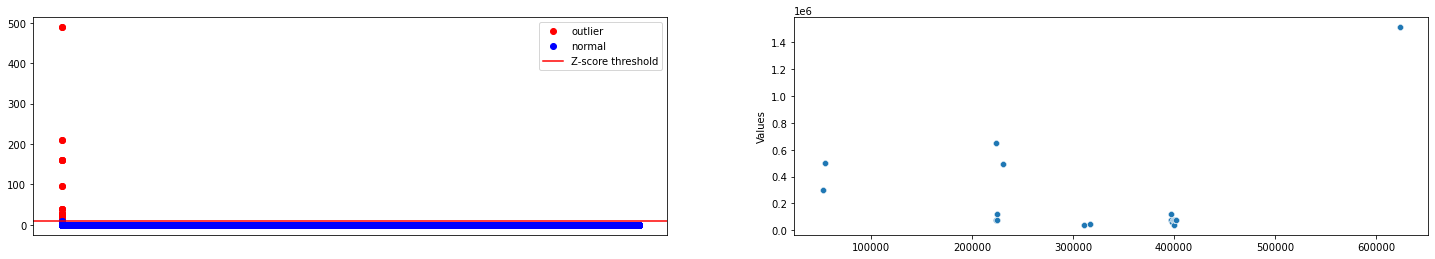

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_revenue.biz_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.34%, 9건


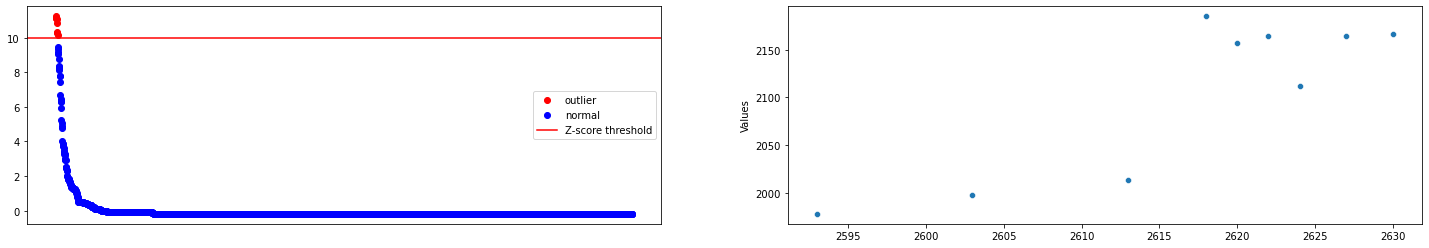

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_revenue.co_pay 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.23%, 6건


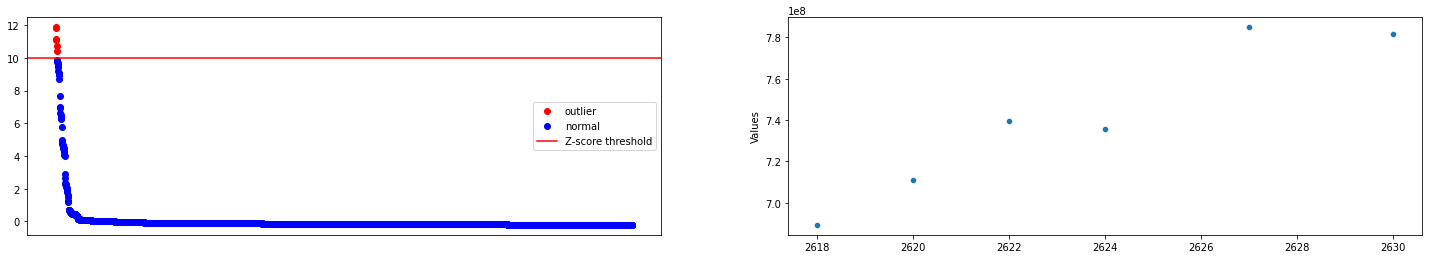

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_revenue.nhis_pay 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.23%, 6건


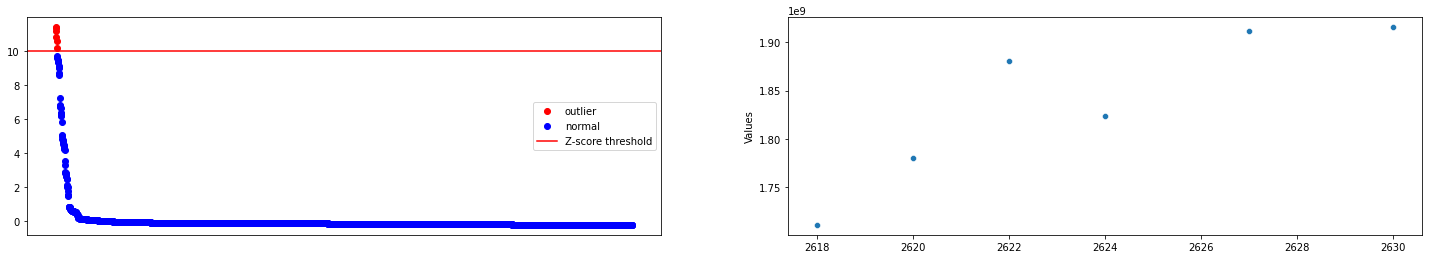

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_revenue.nonbenefit_total_pay 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.23%, 6건


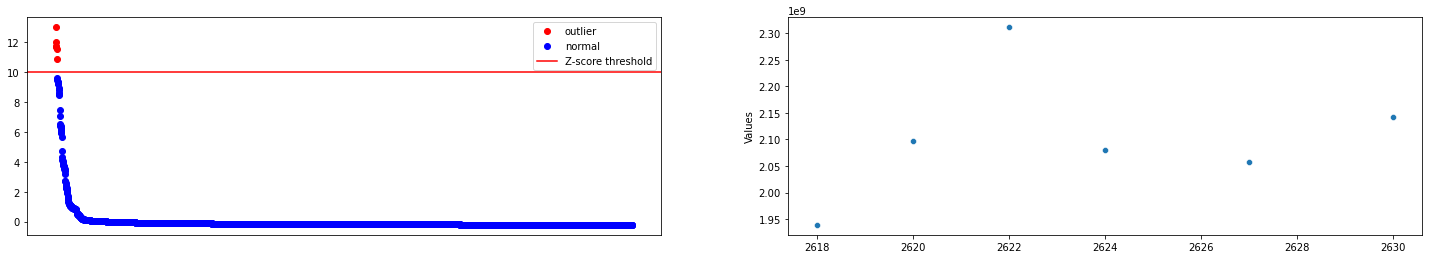

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_revenue.carinsur_pay 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.34%, 9건


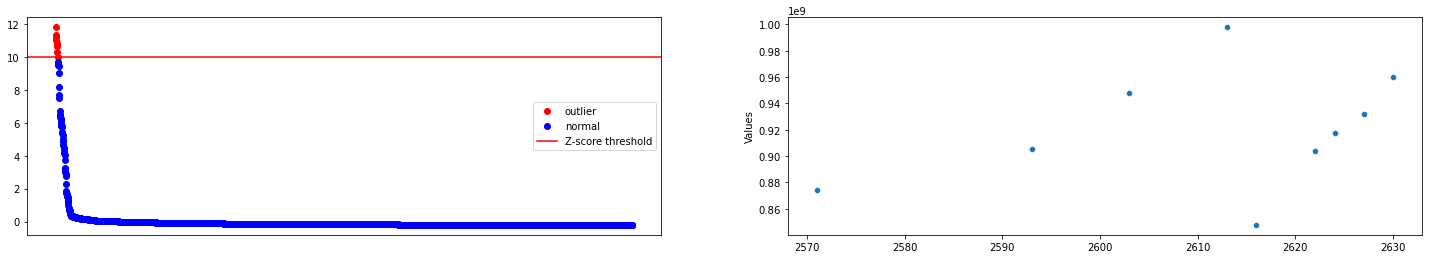

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_revenue.etc_pay 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.15%, 4건


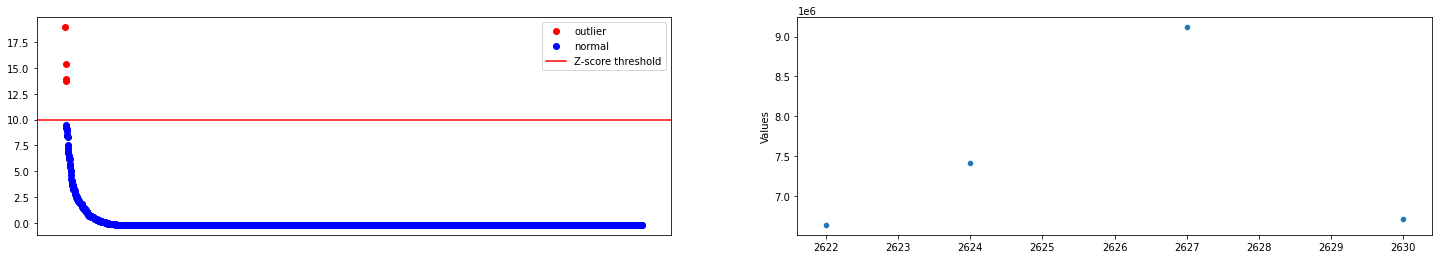

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_revenue.room_pay 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.72%, 19건


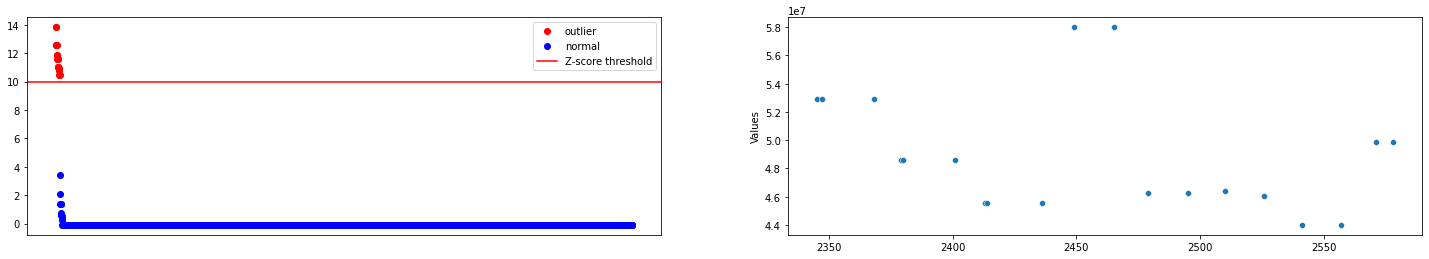

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_revenue.total_pay 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.23%, 6건


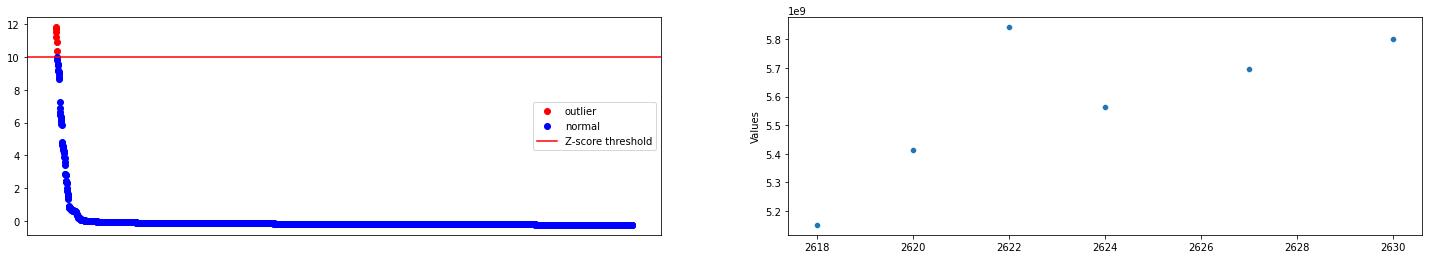

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_revenue.nonbenefit_pay 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.38%, 10건


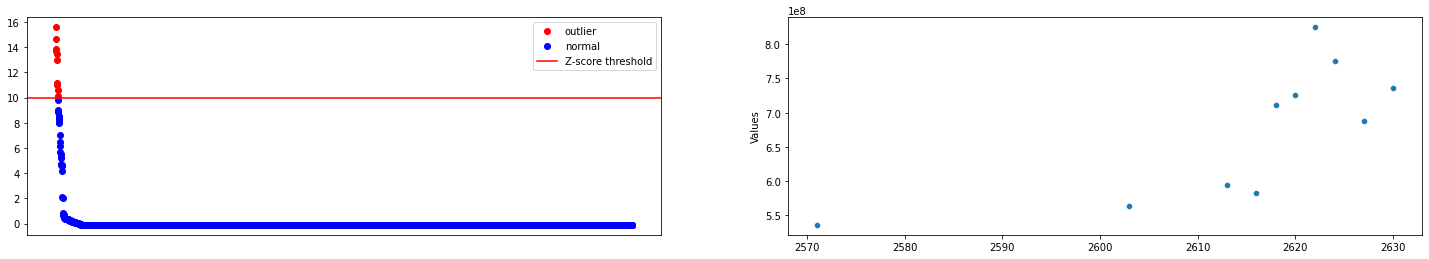

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_revenue.nonbenefit_repay 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.38%, 10건


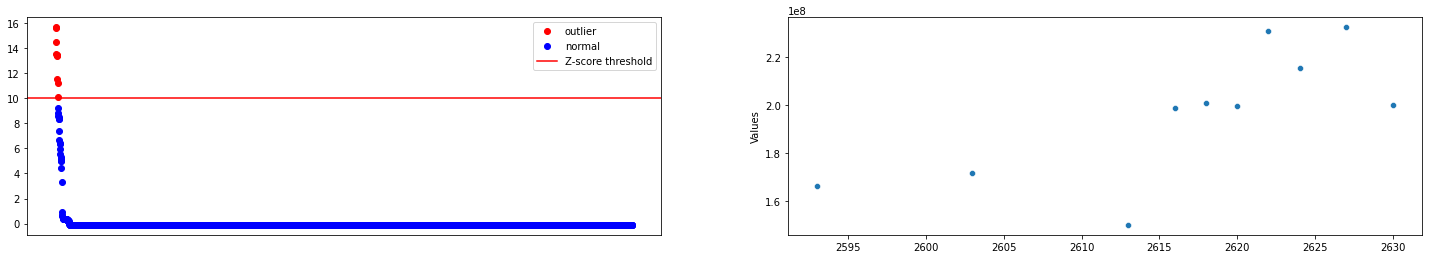

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_revenue.co_pay 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.01%, 9건


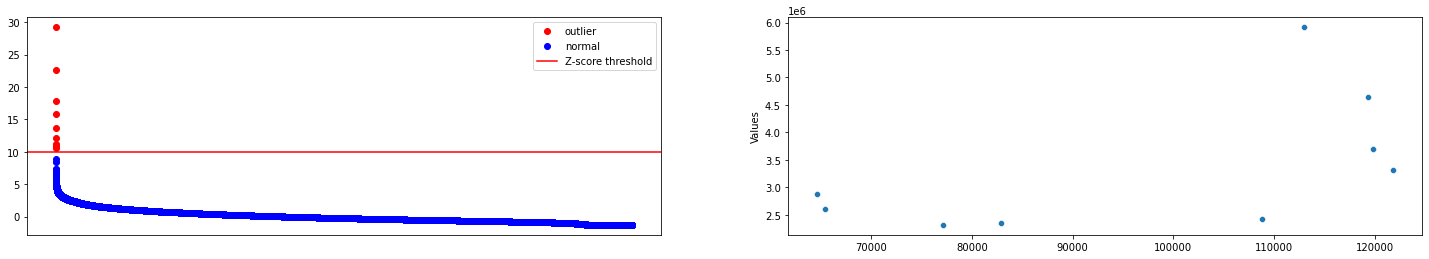

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_revenue.nhis_pay 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.00%, 1건


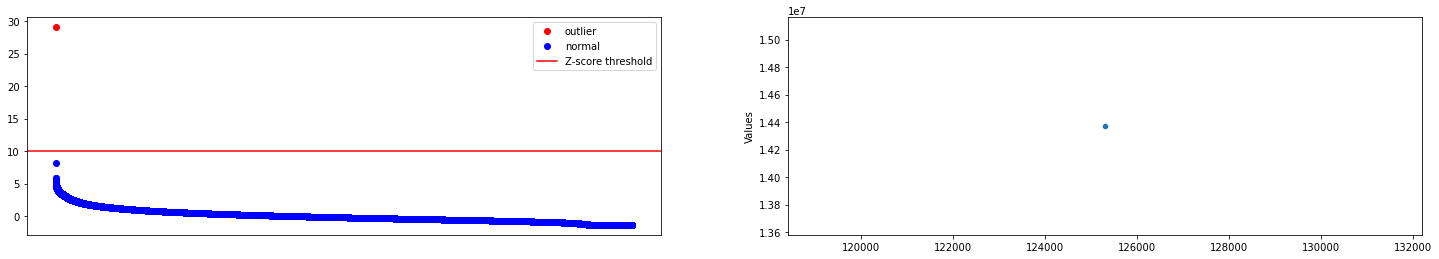

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_revenue.nonbenefit_total_pay 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.07%, 92건


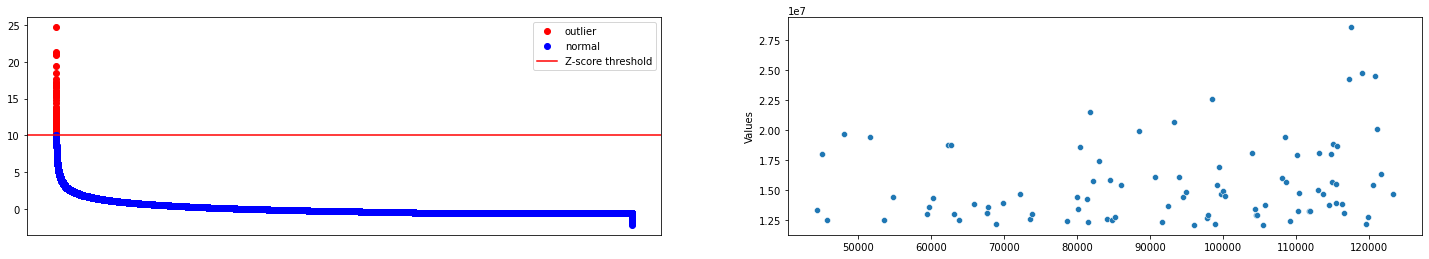

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_revenue.carinsur_pay 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.00%, 5건


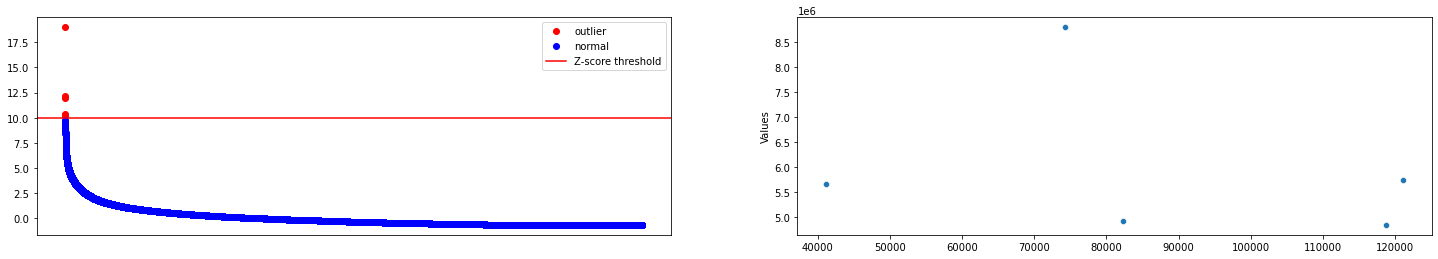

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_revenue.etc_pay 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.22%, 272건


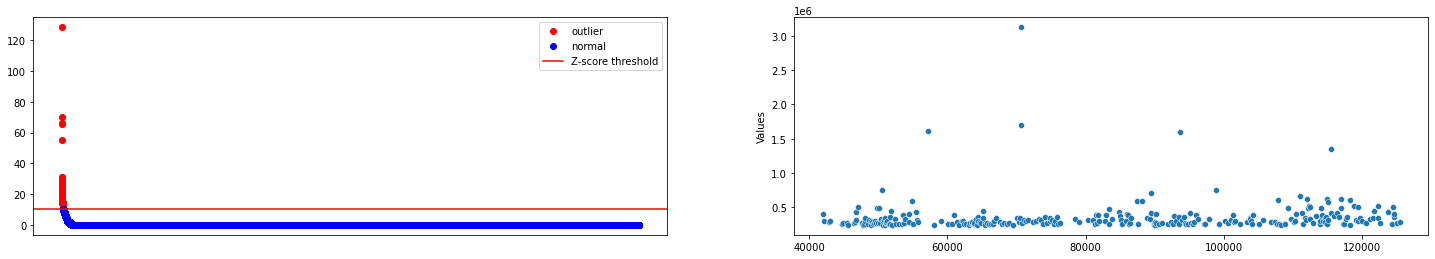

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_revenue.room_pay 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.09%, 119건


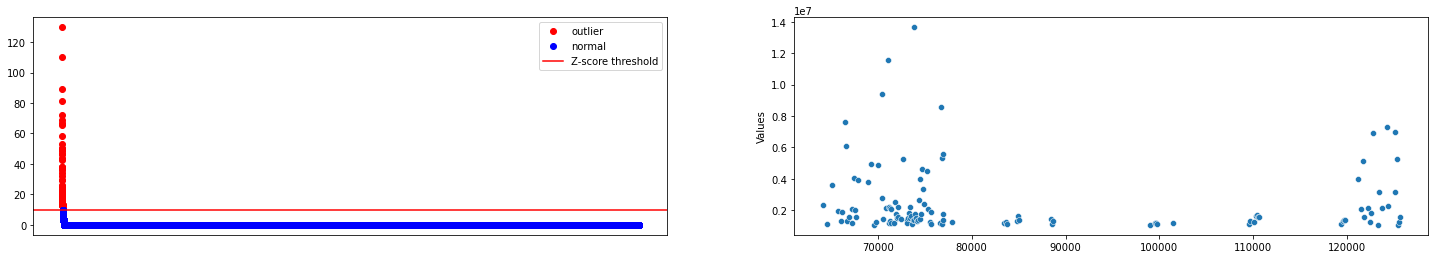

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_revenue.total_pay 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.02%, 25건


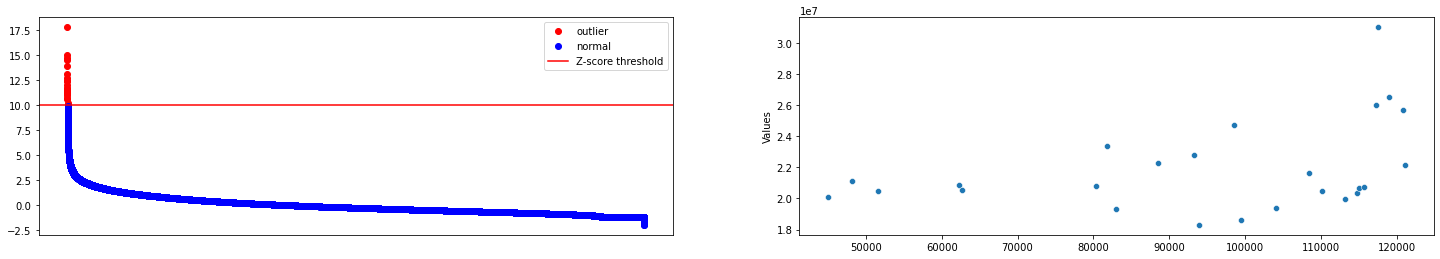

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_revenue.nonbenefit_pay 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.12%, 153건


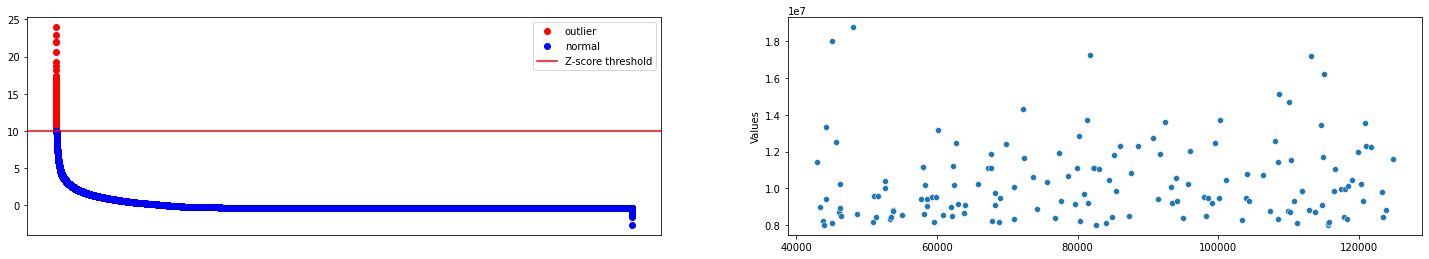

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_revenue.nonbenefit_repay 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.18%, 222건


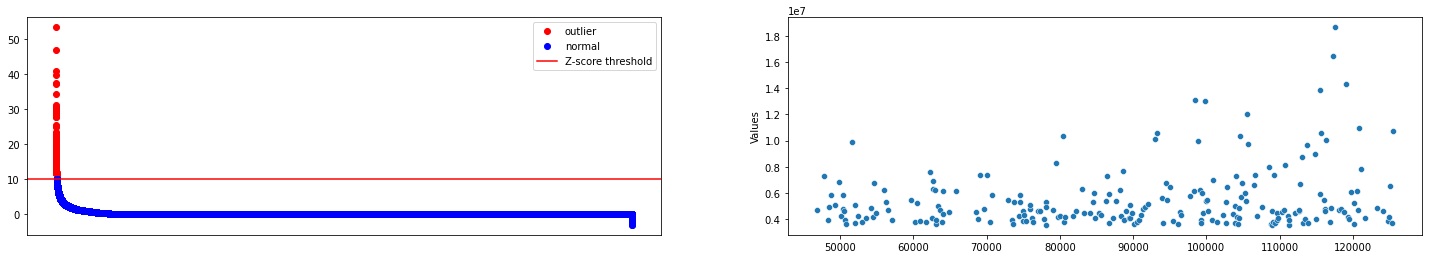

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_patients.biz_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.21%, 6건


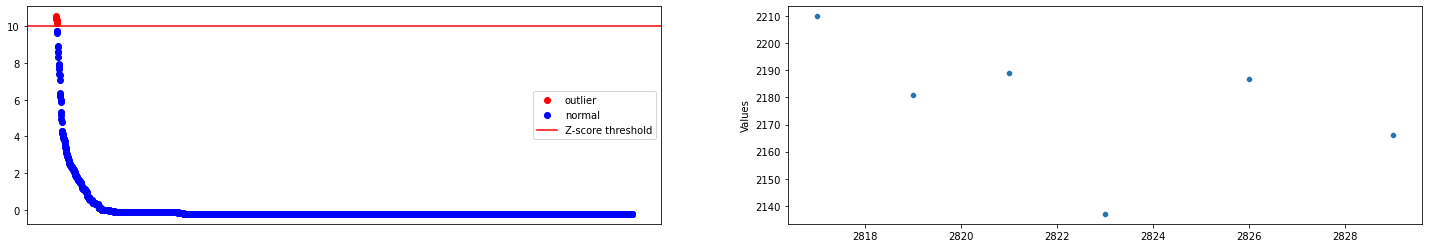

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_patients.visit_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.25%, 7건


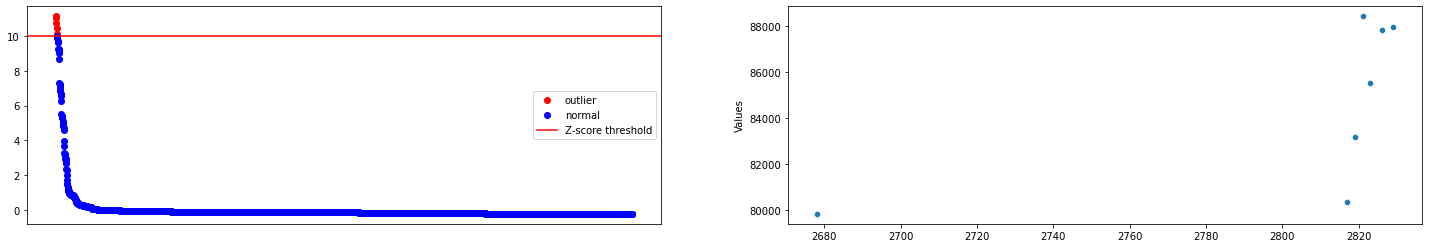

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_patients.fstvisit_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.04%, 1건


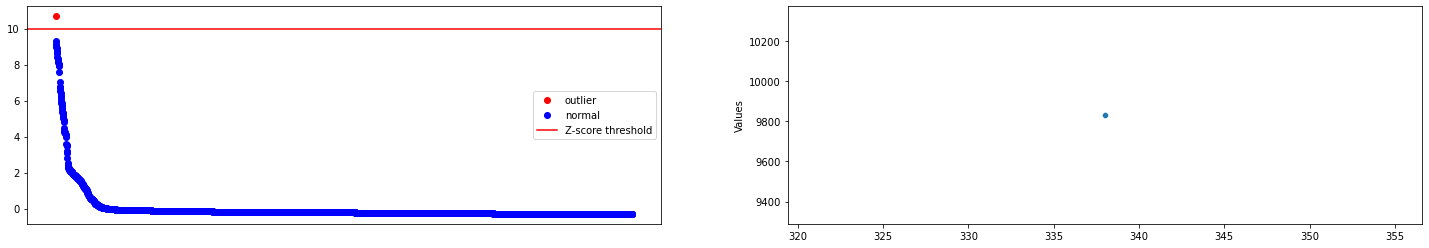

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_patients.revisit_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.42%, 12건


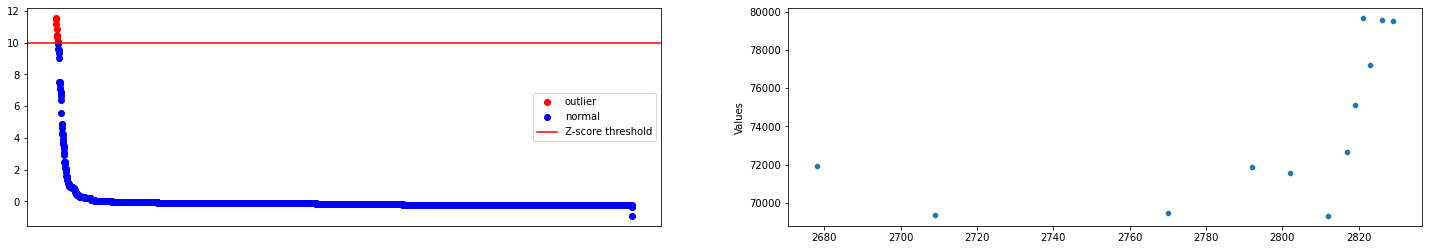

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_patients.refstvisit_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.32%, 9건


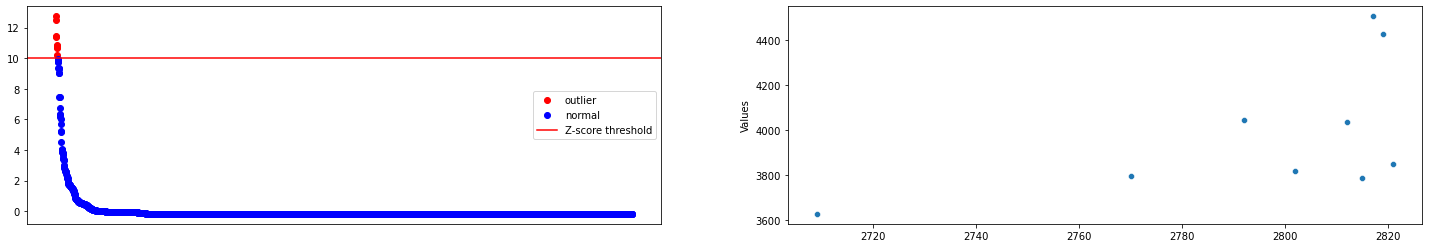

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_patients.carinsur_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.35%, 10건


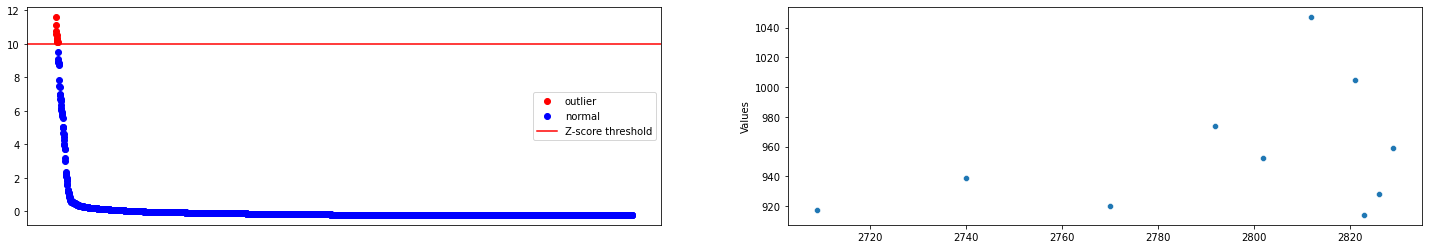

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_patients.pay_tel_cnsl_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.28%, 8건


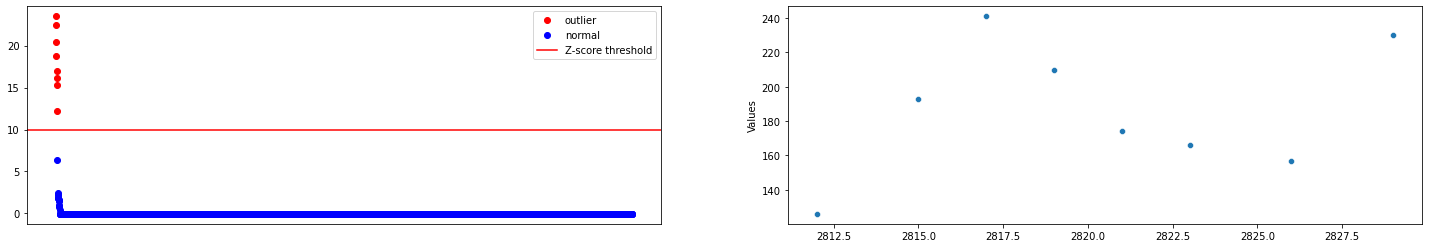

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_patients.simple_tel_cnsl_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.35%, 10건


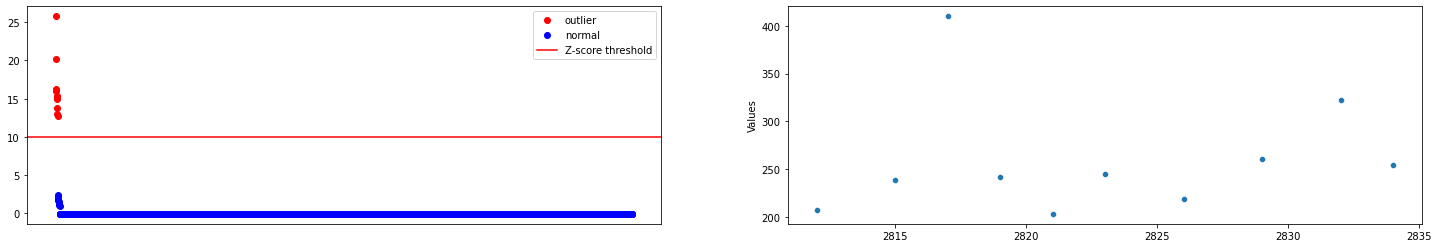

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_patients.document_visit_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.35%, 10건


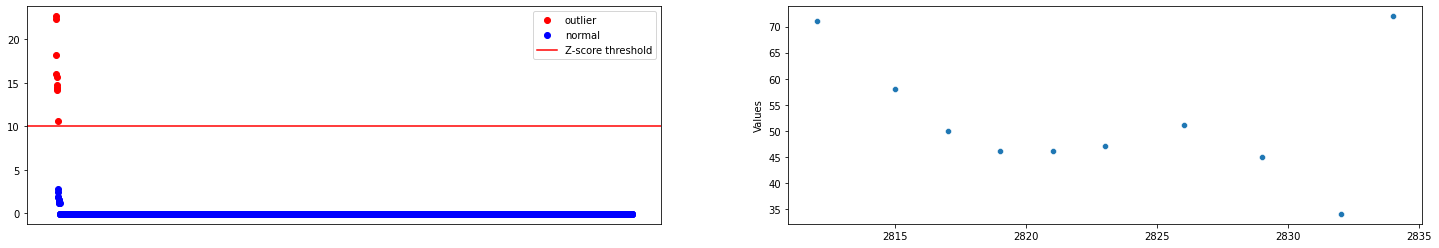

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_patients.room_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.25%, 7건


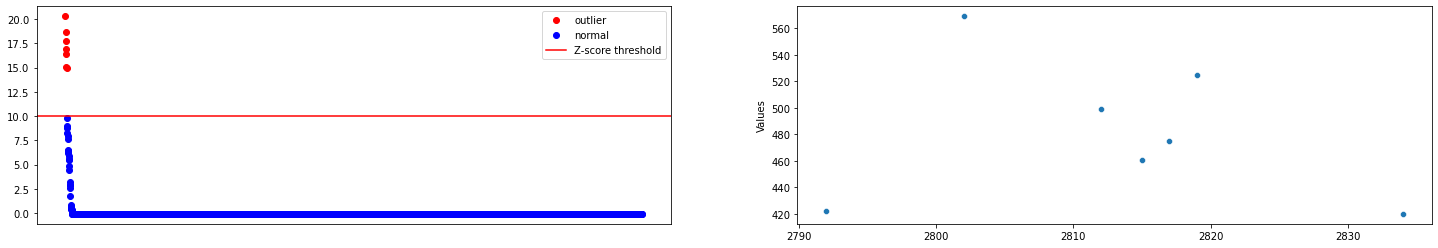

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_patients.senior_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.46%, 13건


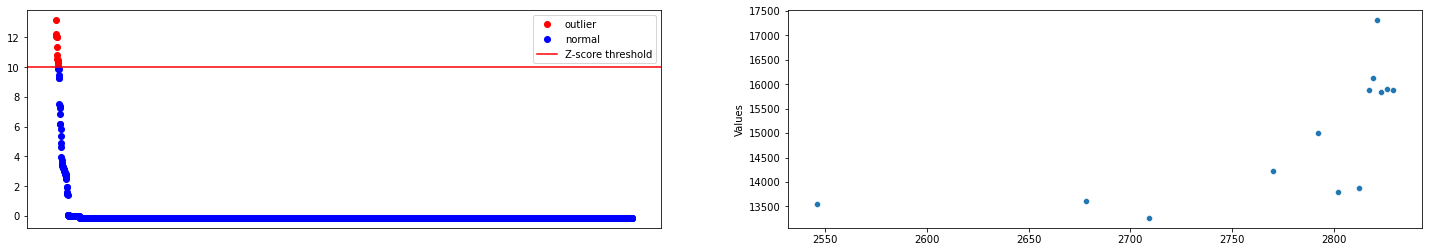

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_patients.fstvisit_attrition_rate 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.63%, 18건


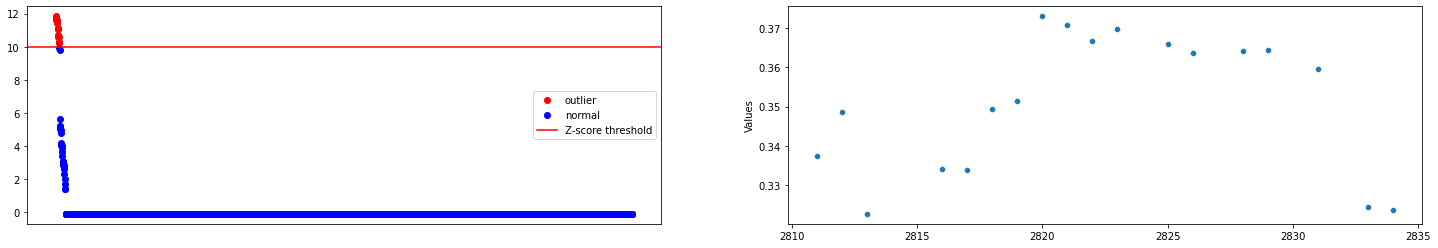

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

monthly_patients.fstvisit_3t3w_rate 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.07%, 2건


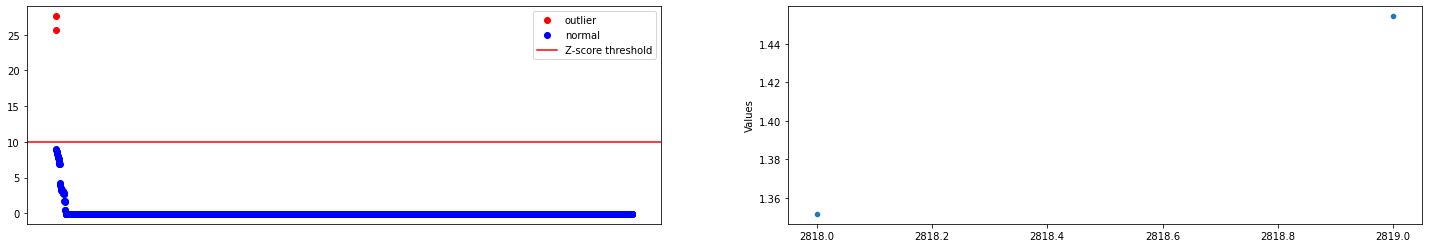

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_nonbenefit_repay.nonbenefit_repay 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.17%, 650건


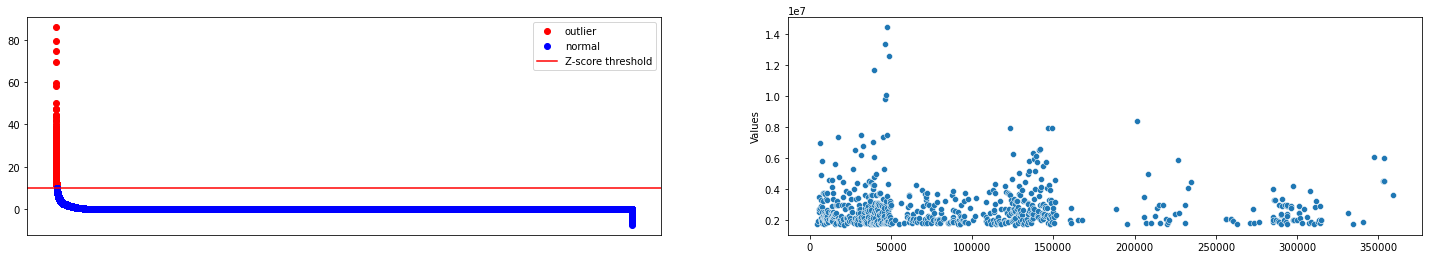

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_funnel.funnel_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.02%, 74건


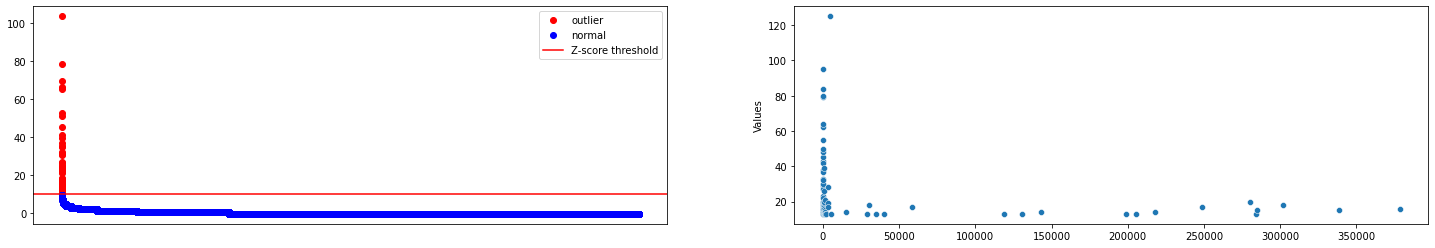

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_appointment.cancel_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.01%, 12건


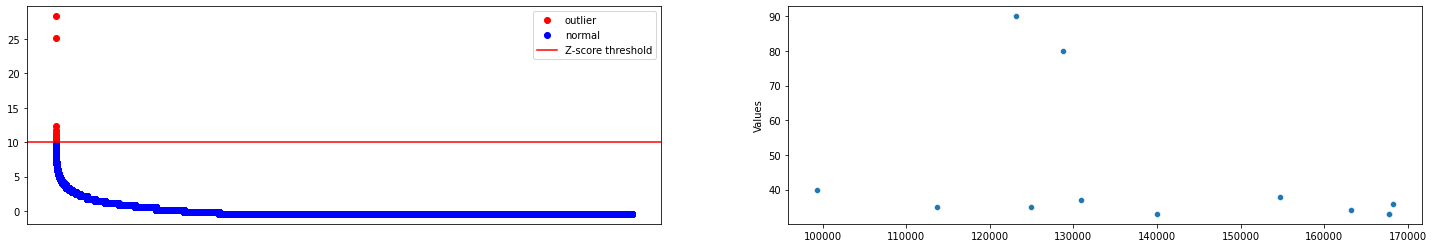

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_appointment.noshow_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.06%, 95건


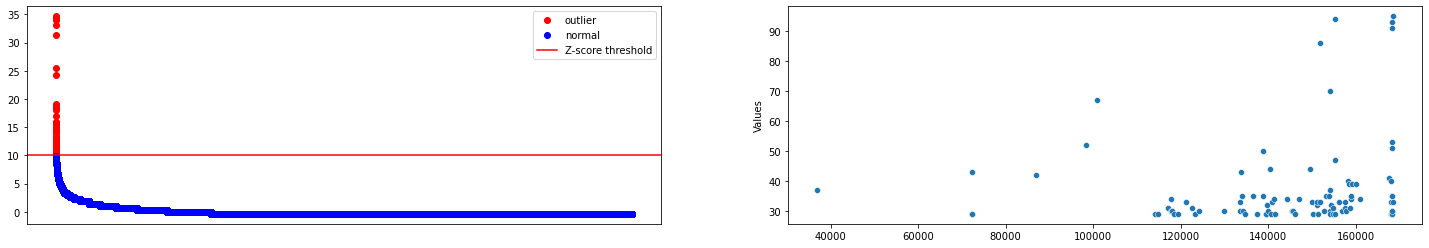

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_nonbenefit_repay_cnsl.nonbenefit_repay_cnsl_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.03%, 26건


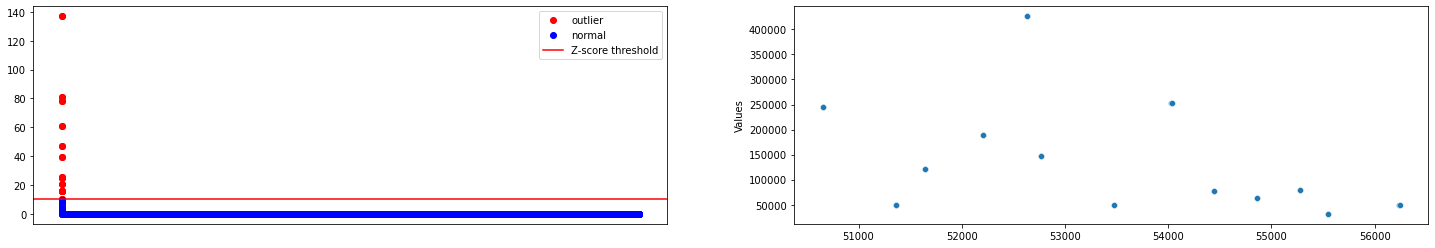

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_nonbenefit_repay_cnsl.nonbenefit_repay_cnsl_succ_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.08%, 64건


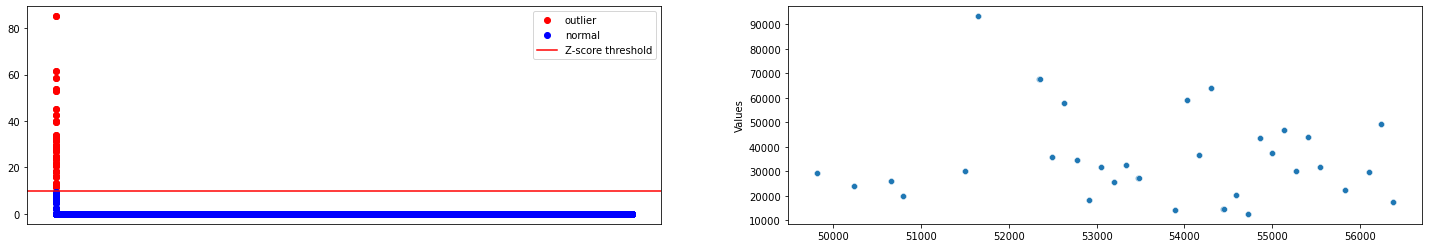

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_nonbenefit_repay_cnsl.nonbenefit_repay_cnsl_fail_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.00%, 4건


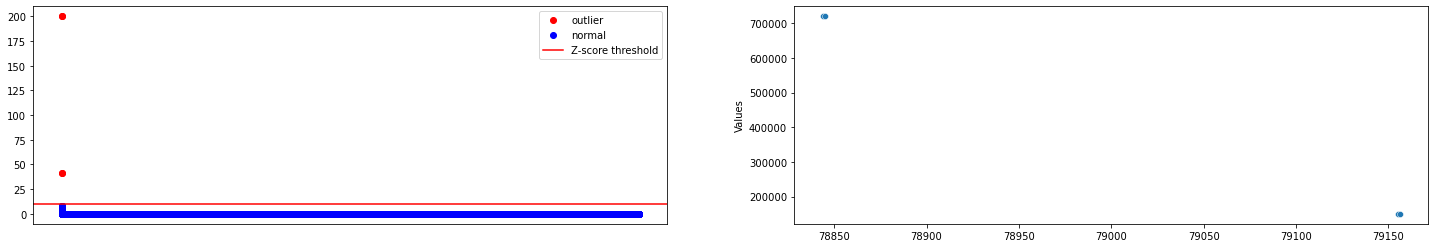

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_nonbenefit_repay_detail_cnsl.nonbenefit_repay_cnsl_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.01%, 46건


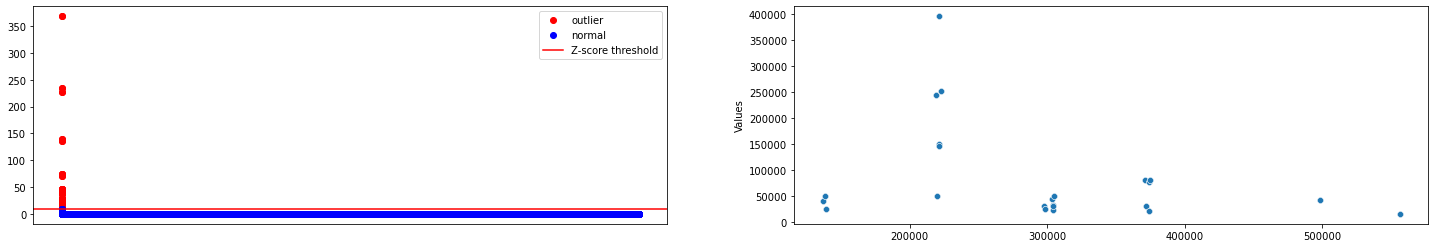

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_nonbenefit_repay_detail_cnsl.nonbenefit_repay_cnsl_succ_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.02%, 100건


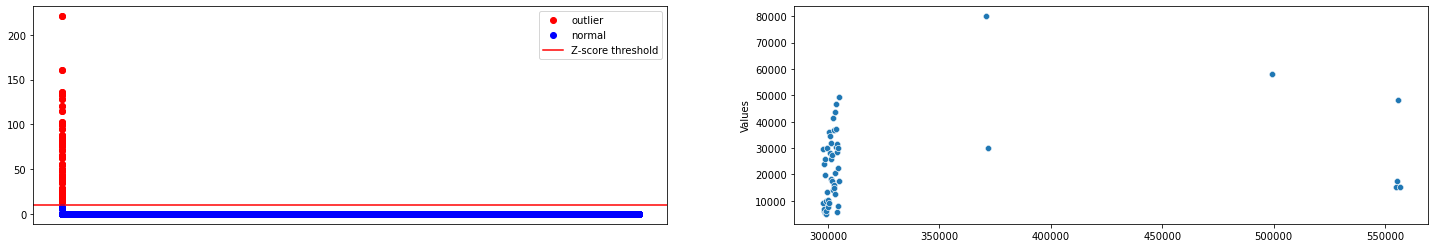

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_nonbenefit_cnsl.nonbenefit_cnsl_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.02%, 20건


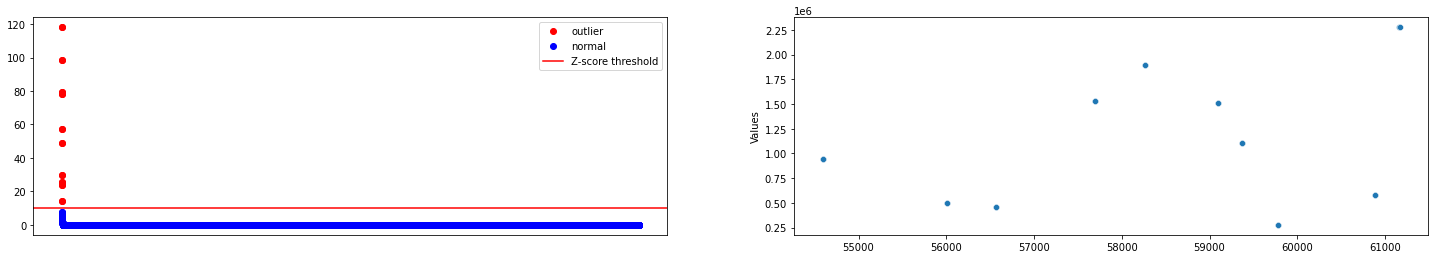

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_nonbenefit_cnsl.nonbenefit_cnsl_succ_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.02%, 14건


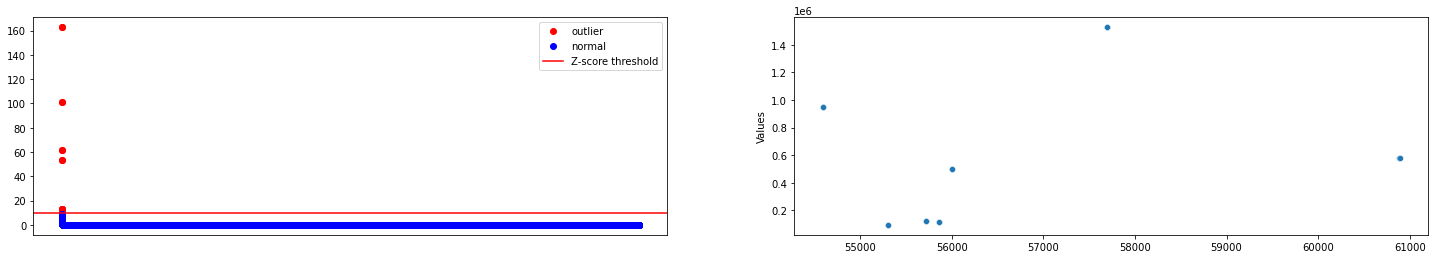

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------

daily_nonbenefit_cnsl.nonbenefit_cnsl_fail_cnt 에서 이상치 발견: [zscore > Threshold(10)]
전체 데이터의 0.02%, 14건


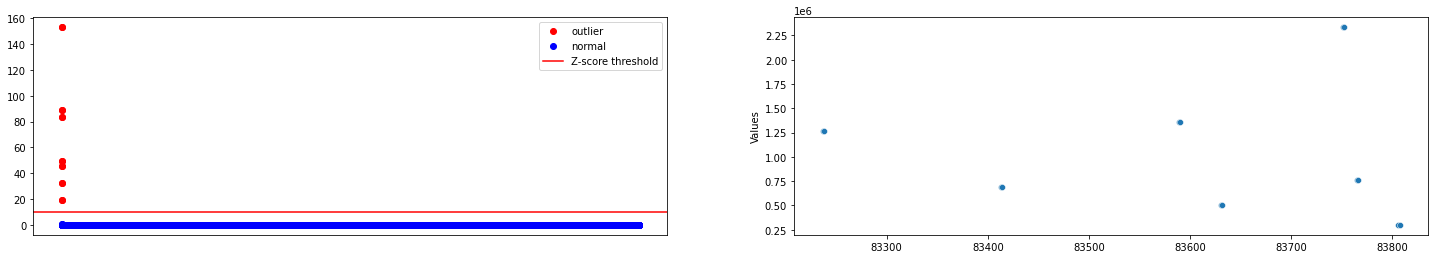

해당 데이터를 파일로 저장했습니다.
---------------------------------------------------



In [19]:
# Z-Score 기반 수치형 컬럼 이상치 검사
from scipy.stats import zscore
from pandas.api.types import is_numeric_dtype

threshold = 10

for df_name in df_list:
    df = globals()[df_name].copy()
    if df.shape[0] > 0:
        for col in df.columns:
            if is_numeric_dtype(df[col]):
                df['z_score'] = zscore(df[col].fillna(0))
                outlier = df.query('abs(z_score) > @ threshold')
                if outlier.shape[0] > 0:
                    print(Colors.YELLOW + f'{df_name}.{col} 에서 이상치 발견: [zscore > Threshold({threshold})]' + Colors.END)
                    print(f'전체 데이터의 {outlier.shape[0] / df.shape[0] * 100:.2f}%, {outlier.shape[0]:,.0f}건')
                    plot_zscore_outlier(df.z_score, threshold, outlier, col)
                    # outlier.to_csv(f'{output_path}-Zscore-outlier-detection-in_{df_name}.csv', index=False)
                    print('해당 데이터를 파일로 저장했습니다.')
                    print('---------------------------------------------------\n')

# 금액 불일치

[monthly_revenue] 금액 불일치:
총액 ≠ 자부담금 + 공단부담금 + 비급여총액 + 자보금액
20.86%, 551건


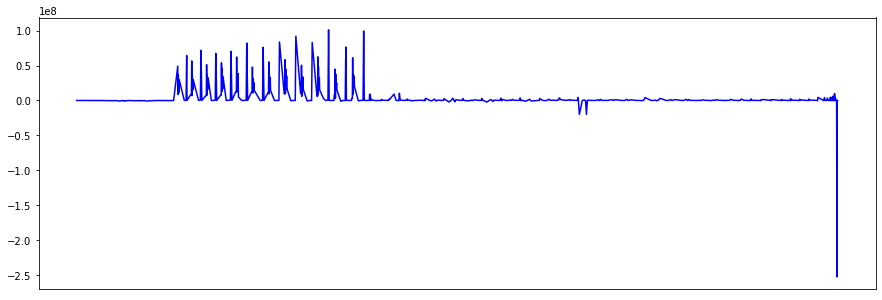

해당 데이터를 이슈 파일로 저장했습니다.
---------------------------------------------------



In [20]:
# total ≠ (co + nhis + nonbenefit_total + carinsur)
df = monthly_revenue.copy()

# total ≠ (co + nhis + nonbenefit_total + carinsur)
outlier = df.fillna(0).query(
    'total_pay - (co_pay + nhis_pay + nonbenefit_total_pay + carinsur_pay) != 0'
)

if outlier.shape[0] > 0:
    outlier['gap'] = outlier.total_pay - (
        outlier.co_pay + outlier.nhis_pay + outlier.nonbenefit_total_pay + outlier.carinsur_pay
        )
    issue_msg = '총액 ≠ 자부담금 + 공단부담금 + 비급여총액 + 자보금액'
    
    print(Colors.YELLOW + '[monthly_revenue] 금액 불일치:' + Colors.END)
    print(issue_msg)
    
    print(f'{outlier.shape[0] / df.shape[0] * 100:.2f}%, {outlier.shape[0]:,.0f}건')
    outlier.gap.plot(
        color='blue', 
        figsize=(15, 5)
        )
    plt.xticks([])
    plt.show()
    
    # outlier.to_csv(f'{output_path}total_pay-mismatch-sum-of-part_pay_in_monthly_revenue.csv', index=False)
    print('해당 데이터를 이슈 파일로 저장했습니다.')
    print('---------------------------------------------------\n')

[monthly_revenue] 금액 불일치:
비급여총액 ≠ 비급여 + 비급여 재결제
81.87%, 2,163건


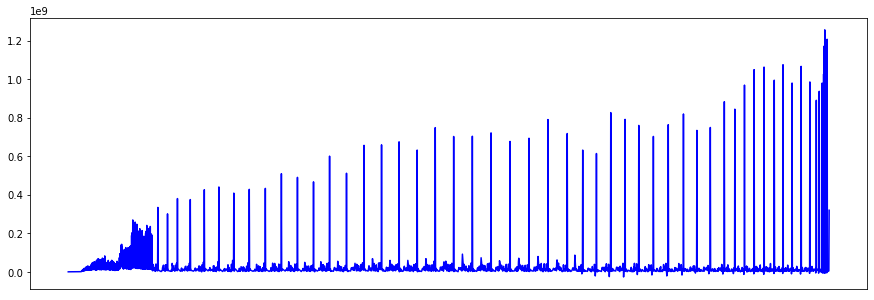

해당 데이터를 이슈 파일로 저장했습니다.
---------------------------------------------------



In [21]:
# total ≠ (nonbenefit + nonbenefit_repay)
df = monthly_revenue.copy()

outlier = df.fillna(0).query(
    'nonbenefit_total_pay - (nonbenefit_pay + nonbenefit_repay) != 0'
)
if outlier.shape[0] > 0:
    outlier['gap'] = outlier.nonbenefit_total_pay - (
        outlier.nonbenefit_pay + outlier.nonbenefit_repay
        )
    issue_msg = '비급여총액 ≠ 비급여 + 비급여 재결제'
    
    print(Colors.YELLOW + '[monthly_revenue] 금액 불일치:' + Colors.END)
    print(issue_msg)
    
    print(f'{outlier.shape[0] / df.shape[0] * 100:.2f}%, {outlier.shape[0]:,.0f}건')
    outlier.gap.plot(
        color='blue', 
        figsize=(15, 5)
        )
    plt.xticks([])
    plt.show()
    
    # outlier.to_csv(f'{output_path}nonbenefit_total_pay-mismatch-sum-of-part_pay_in_monthly_revenue.csv', index=False)
    print('해당 데이터를 이슈 파일로 저장했습니다.')
    print('---------------------------------------------------\n')

[daily_revenue] 금액 불일치:
총액 ≠ 자부담금 + 공단부담금 + 비급여총액 + 자보금액
2.01%, 2,536건


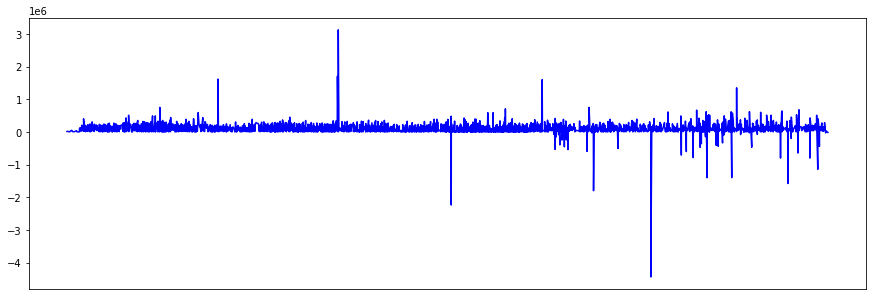

해당 데이터를 이슈 파일로 저장했습니다.
---------------------------------------------------



In [22]:
# total ≠ (co + nhis + nonbenefit_total + carinsur)
df = daily_revenue.copy()

outlier = df.fillna(0).query(
    'total_pay - (co_pay + nhis_pay + nonbenefit_total_pay + carinsur_pay) != 0'
)
if outlier.shape[0] > 0:
    outlier['gap'] = outlier.total_pay - (
        outlier.co_pay + outlier.nhis_pay + outlier.nonbenefit_total_pay + outlier.carinsur_pay
        )
    issue_msg = '총액 ≠ 자부담금 + 공단부담금 + 비급여총액 + 자보금액'
    
    print(Colors.YELLOW + '[daily_revenue] 금액 불일치:' + Colors.END)
    print(issue_msg)
    
    print(f'{outlier.shape[0] / df.shape[0] * 100:.2f}%, {outlier.shape[0]:,.0f}건')
    outlier.gap.plot(
        color='blue', 
        figsize=(15, 5)
        )
    plt.xticks([])
    plt.show()
    
    # outlier.to_csv(f'{output_path}total_pay-mismatch-sum-of-part_pay_in_daily_revenue.csv', index=False)
    print('해당 데이터를 이슈 파일로 저장했습니다.')
    print('---------------------------------------------------\n')

[daily_revenue] 금액 불일치:
비급여총액 ≠ 비급여 + 비급여 재결제
56.01%, 70,595건


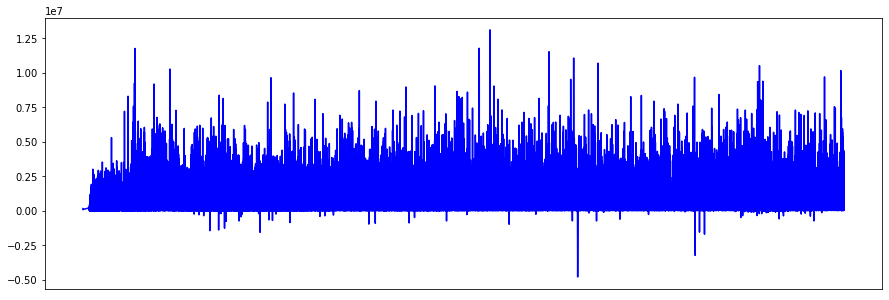

해당 데이터를 이슈 파일로 저장했습니다.
---------------------------------------------------



In [23]:
# total ≠ (nonbenefit + nonbenefit_repay)
df = daily_revenue.copy()

outlier = df.fillna(0).query(
    'nonbenefit_total_pay - (nonbenefit_pay + nonbenefit_repay) != 0'
)
if outlier.shape[0] > 0:
    outlier['gap'] = outlier.nonbenefit_total_pay - (
        outlier.nonbenefit_pay + outlier.nonbenefit_repay
        )
    issue_msg = '비급여총액 ≠ 비급여 + 비급여 재결제'
    
    print(Colors.YELLOW + '[daily_revenue] 금액 불일치:' + Colors.END)
    print(issue_msg)
    
    print(f'{outlier.shape[0] / df.shape[0] * 100:.2f}%, {outlier.shape[0]:,.0f}건')
    outlier.gap.plot(
        color='blue', 
        figsize=(15, 5)
        )
    plt.xticks([])
    plt.show()
    
    # outlier.to_csv(f'{output_path}nonbenefit_total_pay-mismatch-sum-of-part_pay_in_daily_revenue.csv', index=False)
    print('해당 데이터를 이슈 파일로 저장했습니다.')
    print('---------------------------------------------------\n')

# 매출 규칙 불합치

[daily_revenue] 금액 규칙 불합치:
전체 데이터의 0.02%, 27건

쉬는 날 ≠ 매출 없음


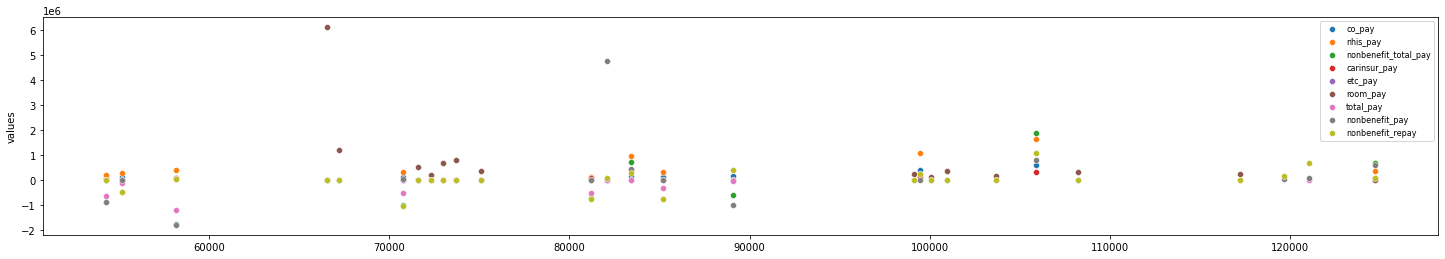

해당 데이터를 이슈 파일로 저장했습니다.
---------------------------------------------------



In [24]:
score_cols = [
    'co_pay', 
    'nhis_pay',
    'nonbenefit_total_pay', 
    'carinsur_pay', 
    'etc_pay', 
    'room_pay',
    'total_pay', 
    'nonbenefit_pay', 
    'nonbenefit_repay'
]

# 쉬는 날 ≠ 노 스코어
df = daily_revenue.copy()
issue_msg = '쉬는 날 ≠ 매출 없음'

outlier = df[((df['biz_cnt'] == 0) | df['biz_cnt'].isna()) & (df.fillna(0)[score_cols].max(axis=1) != 0)]

if outlier.shape[0] > 0:
    print(Colors.YELLOW + f'[daily_revenue] 금액 규칙 불합치:' + Colors.END)
    print(f'전체 데이터의 {outlier.shape[0] / df.shape[0] * 100:.2f}%, {outlier.shape[0]}건\n')
    print(issue_msg)
    plt.figure(figsize=(25, 4))
    for col in score_cols:
        sns.scatterplot(data=outlier, x=outlier.index, y=col, label=col)
    plt.ylabel('values')
    plt.legend(loc='upper right', fontsize=8)
    plt.show()
    
    # outlier.to_csv(f'{output_path}_in_daily_revenue.csv', index=False)
    print('해당 데이터를 이슈 파일로 저장했습니다.')
    print('---------------------------------------------------\n')

# 테이블 간 값 불일치

[daily_nonbenefit vs daily_revenue] 동일피처 값 불일치:
불일치 데이터 수량 : 336,097건
일비급여.비급여금액 ≠ 일매출.비급여


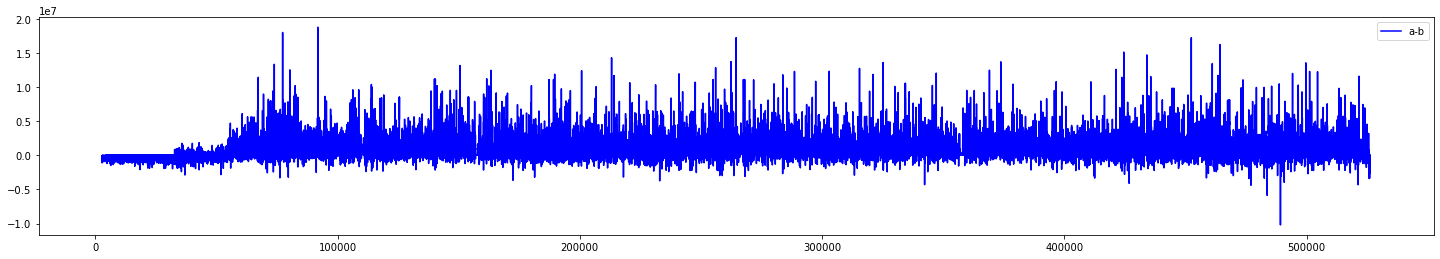

해당 데이터를 이슈 파일로 저장했습니다.
---------------------------------------------------

[daily_nonbenefit_repay vs daily_revenue] 동일피처 값 불일치:
불일치 데이터 수량 : 134,224건
일비급여재결제.비급여재결제금액 ≠ 일매출.비급여재결제


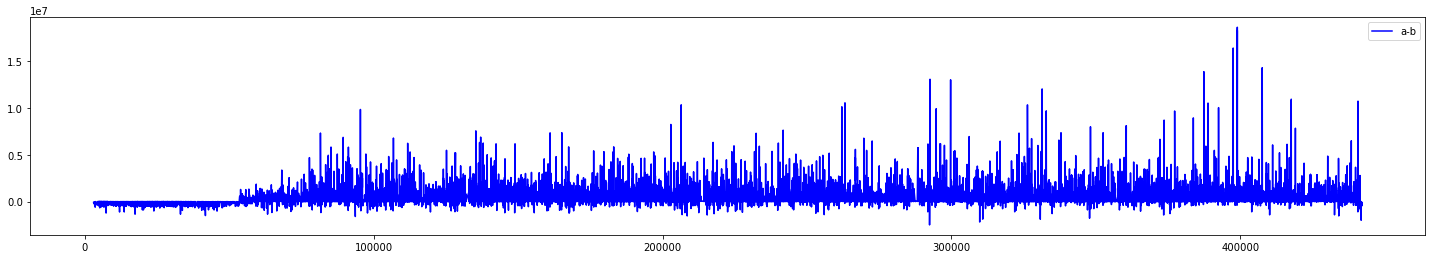

해당 데이터를 이슈 파일로 저장했습니다.
---------------------------------------------------

[daily_nonbenefit_detail_cnsl vs daily_nonbenefit_cnsl] 동일피처 값 불일치:
불일치 데이터 수량 : 2,052건
일비급여상담상세.비급여상담수.일합계 ≠ 일비급여상담.비급여상담수


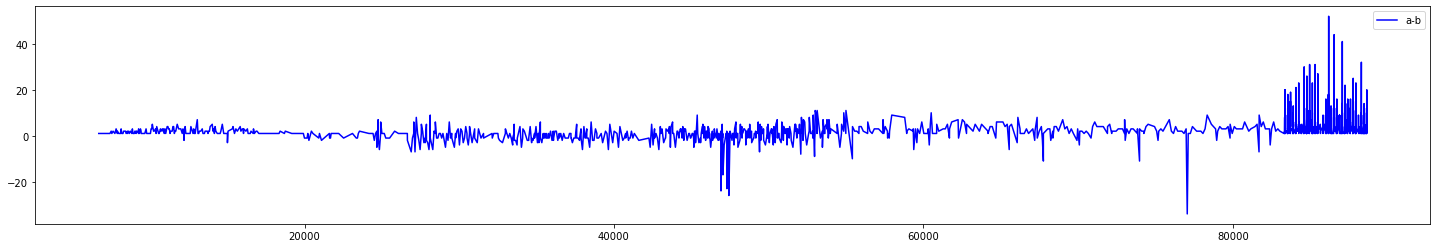

해당 데이터를 이슈 파일로 저장했습니다.
---------------------------------------------------

[daily_nonbenefit_repay_detail_cnsl vs daily_nonbenefit_repay_cnsl] 동일피처 값 불일치:
불일치 데이터 수량 : 1,044건
일비급여재결제상담상세.비급여재결제상담수.일합계 ≠ 일비급여재결제상담.비급여재결제상담수


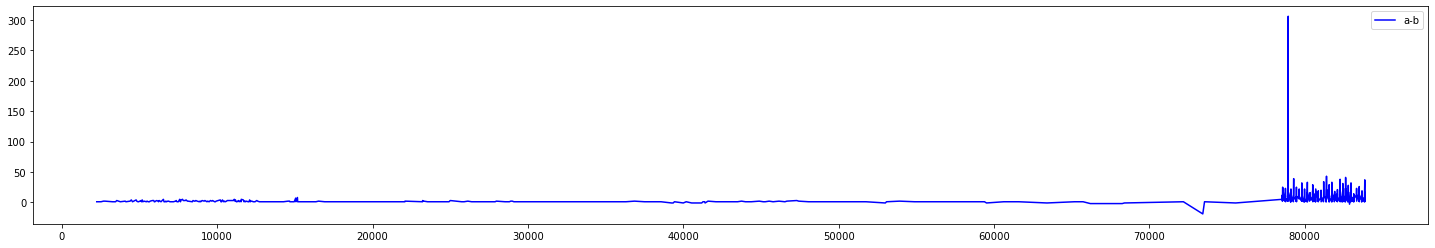

해당 데이터를 이슈 파일로 저장했습니다.
---------------------------------------------------



In [25]:
# 테이블 간 동일피처 값 불일치

# 일비급여.비급여금액 => 일매출.비급여
df1, df2 = daily_nonbenefit, daily_revenue
df1_name, df2_name = 'daily_nonbenefit', 'daily_revenue'
compare_key = 'nonbenefit_pay'
key_cols = ['fk_id', 'biz_dt', 'data_source']
issue_msg = '일비급여.비급여금액 ≠ 일매출.비급여'

print_compared_result(df1, df1_name, df2, df2_name, compare_key, key_cols, issue_msg)

# 일비급여재결제.비급여재결제금액 => 일매출.비급여재결제
df1, df2 = daily_nonbenefit_repay, daily_revenue
df1_name, df2_name = 'daily_nonbenefit_repay', 'daily_revenue'
compare_key = 'nonbenefit_repay'
key_cols = ['fk_id', 'biz_dt', 'data_source']
issue_msg = '일비급여재결제.비급여재결제금액 ≠ 일매출.비급여재결제'

print_compared_result(df1, df1_name, df2, df2_name, compare_key, key_cols, issue_msg)

# 일비급여상담상세.비급여상담수.일합계 => 일비급여상담.비급여상담수
df1, df2 = daily_nonbenefit_detail_cnsl, daily_nonbenefit_cnsl
df1_name, df2_name = 'daily_nonbenefit_detail_cnsl', 'daily_nonbenefit_cnsl'
compare_key = 'nonbenefit_cnsl_cnt'
key_cols = ['fk_id', 'biz_dt', 'data_source']
issue_msg = '일비급여상담상세.비급여상담수.일합계 ≠ 일비급여상담.비급여상담수'

df1 = df1.groupby(key_cols).agg(
    {'biz_cnt' : 'max', 'nonbenefit_cnsl_cnt' : 'sum', 'nonbenefit_cnsl_succ_cnt' : 'sum'}
).reset_index()

print_compared_result(df1, df1_name, df2, df2_name, compare_key, key_cols, issue_msg)

# 일비급여재결제상담상세.비급여재결제상담수.일합계 => 일비급여재결제상담.비급여재결제상담수
df1, df2 = daily_nonbenefit_repay_detail_cnsl, daily_nonbenefit_repay_cnsl
df1_name, df2_name = 'daily_nonbenefit_repay_detail_cnsl', 'daily_nonbenefit_repay_cnsl'
compare_key = 'nonbenefit_repay_cnsl_cnt'
key_cols = ['fk_id', 'biz_dt', 'data_source']
issue_msg = '일비급여재결제상담상세.비급여재결제상담수.일합계 ≠ 일비급여재결제상담.비급여재결제상담수'

df1 = df1.groupby(key_cols).agg(
    {'biz_cnt' : 'max', 'nonbenefit_repay_cnsl_cnt' : 'sum', 'nonbenefit_repay_cnsl_succ_cnt' : 'sum'}
).reset_index()

print_compared_result(df1, df1_name, df2, df2_name, compare_key, key_cols, issue_msg)

# 리서치 | 실험 코드

In [26]:
# LOF 머신러닝 기반 이상치 검사(샘플)
# 문제점은 
# 1.k를 몇으로 할지인 고질적인 문제. 
# 그러나 경험적으로 k=20정도로 하는것이 좋다고한다. 
# 그리고 2. threshold를 얼마로 잡아야할지를 알기 힘들다는 점이다. 
# (파이썬에선 contamination이라는 옵션으로 
# train data중 몇 %가 outlier인지를 우리가 지정해준다. auto는 0.2)
def LOF_toy_sample_code():
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.neighbors import LocalOutlierFactor
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')


    np.random.seed(42)

    # Generate train data
    X_inliers = 0.3 * np.random.randn(100, 2)#정규분포에서 100*2만들고
    X_inliers = np.r_[X_inliers + 2, 2*X_inliers - 2]#각각 2,2 혹은 -2,-2만큼 평행이동한거를 vstack. 즉 cluster 2개

    # Generate some outliers
    X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
    X = np.r_[X_inliers, X_outliers]#-4,4에서 뽑은 outlier와 inlier를 vstack

    n_outliers = len(X_outliers)
    ground_truth = np.ones(len(X), dtype=int)
    ground_truth[-n_outliers:] = -1

    # fit the model for outlier detection (default)
    clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    # use fit_predict to compute the predicted labels of the training samples
    # (when LOF is used for outlier detection, the estimator has no predict,
    # decision_function and score_samples methods).
    y_pred = clf.fit_predict(X) #1,-1로 나온다.
    n_errors = (y_pred != ground_truth).sum()
    X_scores = clf.negative_outlier_factor_

    #fig, ax = plt.subplots()
    plt.title("Local Outlier Factor (LOF)")
    plt.scatter(X[:, 0], X[:, 1], color='b', s=3., label='Data points')
    # plot circles with radius proportional to the outlier scores
    radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min()) #오홍 minmax scaling으로 radius를 정햇네
    plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
                facecolors='none', label='Outlier scores')
    n=np.copy(X_scores)
    n[n>-1.3]=np.nan
    n=np.round(n,2)
    for i, txt in enumerate(n):
        if np.isnan(txt):continue
        plt.annotate(txt, (X[i,0], X[i,1]))
    legend = plt.legend(loc='upper left')
    plt.show()

In [27]:
# IQR 기반 이상치 검사(샘플)
def IQR_toysample_code2():
    from collections import Counter

    def detect_outliers(df, n, features):
        outlier_indices = []
        for col in features:
            Q1 = np.percentile(df[col], 25)
            Q1 = df[col].quantile(25)
            Q3 = df[col].quantile(75)
            IQR = Q3 - Q1
            print(IQR, Q3, Q1)
            outlier_step = 1.5 * IQR
            
            outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
            outlier_indices.extend(outlier_list_col)
        print(outlier_indices)    
        outlier_indices = Counter(outlier_indices)
        print(outlier_indices)
        multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
            
        return multiple_outliers

    outliers_to_drop = detect_outliers(df, 2, score_cols)
    outliers_to_drop